# Exercise: 1D Burgers Equation

The Cauchy Problem to be solved is the Burgers Equation
\begin{align}
&\partial_t u (x,t) + \lambda_1 u \partial_x u (x,t) - \lambda_2 \partial_x^2 u (x,t) = 0 \\
&u(t=0, x) = - \sin \left( \pi \, x \right) \\
&u\left(t, x=\pm 1\right) =  0
\end{align}
with $(t,x) \in [0,1] \times [-1, +1]$, and where $\lambda_1, \lambda_2 \in \mathbb{R}$ are parameters to be found using a parametric PINN model. The furnished data, available at
https://pandora.infn.it/public/burgers-data

obtained with the parameter set
$$
\lambda_1 = 1\,, \quad \lambda_2 = \frac{0.01}{\pi}
$$


------
Extra: reviews on PINN

[1] https://www.nature.com/articles/s42254-021-00314-5

[2] https://arxiv.org/pdf/2202.06416.pdf

[3] https://www.mdpi.com/2504-2289/6/4/140

[4] https://medium.com/@vignesh.g1609/pinn-physics-informed-neural-networks-5f5f05bf7231

[5] https://ocw.mit.edu/courses/18-152-introduction-to-partial-differential-equations-fall-2011/29c6f7ee914a1d804899781f9f604f49_MIT18_152F11_lec_24.pdf , https://ocw.mit.edu/courses/18-152-introduction-to-partial-differential-equations-fall-2011/download/

In [ ]:
import os
from typing import Type, Union
import gc
import tqdm
import math
from collections import OrderedDict
try:
    import tqdm
except:
    %pip install tqdm
    import tqdm

from scipy import io
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
import matplotlib.pyplot as plt

Device: cpu


## 0. Download data

In [ ]:
!wget https://pandora.infn.it/public/burgers-data/dl/burgers.mat

--2024-03-26 16:46:00--  https://pandora.infn.it/public/burgers-data/dl/burgers.mat
Resolving pandora.infn.it (pandora.infn.it)... 131.154.52.50
Connecting to pandora.infn.it (pandora.infn.it)|131.154.52.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157214 (154K) [application/force-download]
Saving to: ‘burgers.mat’

burgers.mat         100%[===================>] 153.53K   439KB/s    in 0.3s    

2024-03-26 16:46:01 (439 KB/s) - ‘burgers.mat’ saved [157214/157214]



In [ ]:
data = io.loadmat('burgers.mat')
x_data, t_data = data['x'], data['t']
u_sol = data['usol']
x, t = np.meshgrid(x_data, t_data)

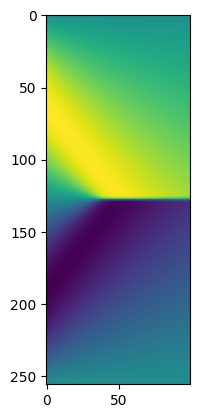

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(u_sol)
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure([go.Surface(
    x=x, y=t, z = u_sol.T,
)])

fig.show()

In [ ]:
data_dict = {
    'x' : x.flatten() ,
    't' : t.flatten() ,
    'u_sol' : u_sol.T.flatten() ,
}
#df = pd.DataFrame(data_dict)

## 1. Define a DNN as torch module

In [ ]:
class PINN_DNN(nn.Module):
    """
    Basic Deep Neural Network
    """
    def __init__(
        self,
        n_inputs : int,      # number of inputs, e.g. x,y,z,t,....
        n_outputs: int,      # number of outputs, e.g. u,v,P, T, ....
        hidden_dims: list,   # number of hidden layers
        dropout: float = 0.2,# Dropout
        activation_func = nn.Tanh(), # activation function hidden layers
    ):
        super(PINN_DNN, self).__init__()
        self.n_layers = len(hidden_dims)
        self.dropout_prob = dropout
        self.activation_func = activation_func

        self.lambda1 = nn.Parameter(data = torch.tensor([1.0])  , requires_grad=True)
        self.lambda2 = nn.Parameter(data = torch.tensor([0.003]), requires_grad=True)

        layers = OrderedDict()
        for i in range(self.n_layers):
            # Input layer
            if i == 0:
                layers[f"fc{i}"] = nn.Linear(n_inputs, hidden_dims[0], bias=False)
            # Hidden Layer(s)
            else:
                layers[f"fc{i}"] = nn.Linear(hidden_dims[i-1], hidden_dims[i], bias=False)
            layers[f"act_{i}"]   = self.activation_func
            layers[f"dropout_{i}"] = nn.Dropout(p=self.dropout_prob)

        # Output Layers
        layers[f"fc_{i+1}"] = nn.Linear(hidden_dims[-1], n_outputs, bias=True)

        self.network = nn.Sequential(layers)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialisation method for the DNN layers weights (and biases)
        """
        for layer in self.network:
            if not isinstance(layer, nn.Linear):
                continue
            nn.init.normal_(layer.weight, std=1 / math.sqrt(layer.out_features) )
            if layer.bias is not None:
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(layer.weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(layer.bias, -bound, bound)

    def forward(self, x):
        return self.network(x)

## 2. Define the PDE class with torch.autograd

In [ ]:
class Burgers_1D_PDE:
    """
        Class computing the 1D Burgers PDE equation:
            u_t + lambda_1 u u_x - lambda_2 u_xx = 0
        Notice that we can conveniently rewrite it as
            u_t + (1/2)*(u**2)_x- ν u_xx = 0

        Methods:
            compute_heat      (coords, pred_funcs): returns the computed Heat eq.
    """
    def __init__(self):
        pass

    def compute_burgers(
        self,
        coords: torch.Tensor,
        pred_func: torch.Tensor ,
        lambda1: torch.Tensor,
        lambda2: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute 1D Heat equation
            u_t + lambda_1 u u_x - lambda_2 u_xx
        It should equate to zero.

        Args:
            coords    (torch.Tensor): (t,x) coords.
            pred_func (torch.Tensor): (u) evaluated at (t,x)
        """
        u = pred_func[:,0]
        # compute derivatives
        u_t  = self.get_derivative(pred_func, coords, 1)[:,0]

        u_x  = self.get_derivative(pred_func, coords, 1)[:,1]
        u_xx = self.get_derivative(u_x, coords, 1)[:,1]

        # return evaluated PDE
        return u_t + lambda1 * u * u_x - lambda2 * u_xx

    def get_derivative(self, y, x, n: int = 1):
        """
        General formula to compute the n-th order derivative of y = f(x) with respect to x
        """
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y).to(y.device), create_graph=True, retain_graph=True, allow_unused=True)[0]
        return self.get_derivative(dy_dx, x, n - 1)

## 3. Boundary Conditions

In [ ]:
class Burgers_1D_BC:
    def __init__(
        self,
        cost_function = nn.MSELoss()
    ):
        # Cost function
        self.cost_function = cost_function

    def boundary_cond(self, coords: torch.Tensor, pred_func: torch.Tensor) -> torch.Tensor:
        """
        Class for computing BC
            u(t, x=±1) = 0

        Args:
             coords    (torch.Tensor) : The coords at the spatial boundary
             pred_func (torch.Tensor) : The predicted function at those points
        Returns
             bc_loss (torch.tensor)
        """
        true_b  = torch.zeros_like(pred_func)
        bc_loss = self.cost_function(pred_func, true_b)

        return torch.mean( bc_loss )

    def initial_cond(self, coords: torch.Tensor, pred_func: torch.Tensor) -> torch.Tensor:
        """
        Class for computing IC
            u(x, t=0) = - sin(π x)

        Args:
             coords    (torch.Tensor) : The coords at the Initial Time
             pred_func (torch.Tensor) : The predicted function at those points
        Returns
             ic_loss (torch.tensor)
        """
        pi_fact = float(torch.pi)
        x = coords[:, 1].detach().cpu().numpy()
        true_b  = - np.sin(pi_fact * x)

        ic_loss = self.cost_function(pred_func,  torch.tensor(true_b, requires_grad=False).unsqueeze(-1).to(pred_func.device))

        return torch.mean( ic_loss )

## 4. Assemble PINN model

--------------
Refs:

[1] https://towardsdatascience.com/improving-pinns-through-adaptive-loss-balancing-55662759e701 , https://github.com/rbischof/relative_balancing , https://arxiv.org/abs/2110.09813

[2] https://docs.nvidia.com/deeplearning/modulus/modulus-v2209/user_guide/theory/advanced_schemes.html#softadapt , original paper: https://arxiv.org/pdf/1912.12355.pdf

[3] https://docs.nvidia.com/deeplearning/modulus/modulus-v2209/user_guide/theory/advanced_schemes.html#learning-rate-annealing . original paper https://arxiv.org/pdf/2001.04536.pdf



In [ ]:
import json

def write_line_to_file(LOG_FILE: str, log_line: str):
    with open(LOG_FILE, 'a') as f:
        f.write(log_line)

def store_hyp_dict(json_file: str, hyperparam_kwargs: dict, _indent: int = 4):
    with open(json_file, 'w') as fp:
        json.dump(hyperparam_kwargs, fp, indent=_indent)

In [ ]:
# Checkpoints (to save model parameters during training)
# this is implemented by writing a python class that uses the torch.save method
class SaveBestModel:
    def __init__(
        self,
        model_name: str = 'best_model',
        best_valid_loss = float('inf')
    ): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.model_name = model_name

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{self.model_name}.pth')

In [ ]:
import datetime
import time

class PINN(nn.Module):
    """
    Full PINN Class for the FORWARD problem.

    It incorporates:
        1. The PINN DNN (in self.DNN)
        2. The PDE      (in self._PDE)
        3. The BC       (in self._BC)

    It exposes the train_model() method to solve the PINN forward problem, by Performing a training with ADAM optimiser

    The train_model() method is thus:
        1. ADAM loop
            1.1. call training_step() for adam
            1.2. Store best model
            1.3. Perform step for learning rate stepper
            1.4. Logs
            1.5. Check if patience reached;

    Args:
        For Args see init method.

    Methods:
        init_model      ()  : init the model.
        load_best_model ()  : reload the best model.
        forward         (x) : DNN Forward passing
        pde_loss        (x, pred_funcs) : Compute PDE loss using self.cost_function
        ic_loss         (x, pred_funcs) : Compute IC  loss using BC class
        bc_loss         (x, pred_funcs) : Compute BC  loss using BC class
        soft_adapt      (losses, previous_losses, eps = 1e-8) : perform SoftAdapt algorithm.
        generate_coords ()  : generate the coords
        closure         ()  : method performing the backprop. Fundamental for L-BFGS part, it is also used for ADAM.
        training_step   (epoch, use_adam)   : Single training step.
        train_model     ()  : Main method. Trains the model.
        store_training_df   ()  : utils method to store the training history as csv
    """
    def __init__(
        self,
        # DNN
        n_inputs : int = 2,      # number of inputs, e.g. x,y,z,t,....
        n_outputs: int = 1,      # number of outputs, e.g. u,v,P, T, ....
        hidden_layers: list = [4, 8, 16, 8], # number of hidden layers
        dropout: float = 0.2,  # Dropout
        activation_func = nn.Tanh(),
        learning_rate: float = 0.001,
        # True data
        data_dict: dict = data_dict,
        # Geometry
        time_interval : list = [0.0,  +1.0] ,
        space_interval: list = [-1.0, +1.0] ,
        # Training
        patience_training: int = 200,
        epochs: int = 1000,
        N_batches: int = 32,
        patience_lr: int = 50,
        # Soft adapt
        use_softadapt : bool = False,
        softadapt_starting_epoch : int = 5,
        # Loss weights
        weight_rec: float = 1.0,
        weight_pde: float = 1.0,
        weight_bc : float = 1.0,
        weight_ic : float = 1.0,
        # dataloaders
        fun_batch_size: int = 4096,
        pde_batch_size: int = 4096,
        bc_batch_size: int = 1024,
        ic_batch_size: int = 1024,
        # device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        # Model name
        BASE_PATH_TO_STORE: str = '.',
        model_name: str = 'pinne_heat',
    ):
        """
        Init method.

        Args:
            n_inputs    (int, optional)     : Number of DNN inputs. Defaults to 2.
            n_outputs   (int, optional)     : Number of DNN outputs. Defaults to 1.
            hidden_layers (list, optional)  : Listof hidden layers dims. Defaults to [4, 8, 16, 8].
            learning_rate (float, optional) : Adam Learning rate. Defaults to 0.001.
            data_dict     (dict) : Data Dict.
            patience_training       (int, optional)     : Patience in ADAM training. Defaults to 200.
            epochs                  (int, optional)     : Total Number of ADAM epochs. Defaults to 1000.
            N_batches               (int, optional)     : Number of ADAM Batches. Defaults to 32.
            patience_lr             (int, optional)     : Patience for LR stepper. Defaults to 50.
            use_softadapt            (bool, optional) : Boolean to decide whether to use SoftAdapt algorithm. Defaults to True,
            softadapt_starting_epoch (int, optional)  : SoftAdapt starting epoch. Defaults to 5.
            weight_rec  (float, optional)   : Reconstruction Loss weight. Defaults to 1.0.
            weight_pde  (float, optional)   : PDE Loss weight. Defaults to 1.0.
            weight_bc   (float, optional)   : BC Loss weight. Defaults to 1.0.
            weight_ic   (float, optional)   : IC Loss weight. Defaults to 1.0.
            fun_batch_size  (int, optional) : Batch Size for computing rec loss. Defaults to 4096.
            pde_batch_size  (int, optional) : Batch Size for computing pde loss. Defaults to 4096.
            bc_batch_size   (int, optional) : Batch Size for computing bc  loss. Defaults to 1024.
            device      (_type_, optional)  : Device. Defaults to torch.device("cuda:0" if torch.cuda.is_available() else "cpu").
            BASE_PATH_TO_STORE  (str, optional) : Path to store training and model data. Defaults to '.'.
            model_name          (str, optional) : Model name. Defaults to 'pinne_heat'.
        """
        super(PINN, self).__init__()
        # geometry
        self._t_min , self._t_max = time_interval
        self._x_min , self._x_max = space_interval
        # ==== DNN PART ==================
        self.n_inputs      = n_inputs
        self.n_outputs     = n_outputs
        self.hidden_layers = hidden_layers
        self.n_layers      = len(hidden_layers)
        self.dropout_prob  = dropout
        self.activation_func = activation_func
        self.learning_rate = learning_rate
        self.device = device
        # ==== SoftAdapt PART ==================
        self.use_softadapt = use_softadapt
        self.softadapt_starting_epoch = softadapt_starting_epoch if softadapt_starting_epoch >= 2 else 2
        # ====  PDE params PART ==================
        self.data_dict = data_dict
        self.df_data = pd.DataFrame(data_dict)
        # ==== PINN-DNN PART ==================
        # Dataloader
        self.fun_batch_size = fun_batch_size
        self.pde_batch_size = pde_batch_size
        self.ic_batch_size  = ic_batch_size
        self.bc_batch_size  = bc_batch_size
        self.N_batches   = N_batches
        # training vars
        self.patience_training = patience_training
        self.epochs = epochs
        self.patience_lr     = patience_lr
        # Loss weights
        self.weight_rec = weight_rec
        self.weight_pde = weight_pde
        self.weight_bc  = weight_bc
        self.weight_ic  = weight_ic
        # DNN
        self.model_kwargs = {
           "n_inputs"     : self.n_inputs,
            "n_outputs"   : self.n_outputs,
            "hidden_dims" : self.hidden_layers,
            "dropout"     : self.dropout_prob,
        }
        self.init_model()
        # Optimisers
        self.optimizer = torch.optim.Adam(
            self.DNN.parameters(),
            lr=self.learning_rate,
        )
        # LR scheduler
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor  = 0.1, # Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
            patience= self.patience_lr, #  Number of epochs with no improvement after which learning rate will be reduced.
        )

        # cost function
        self.cost_function = nn.MSELoss() # Mean squared error

        # ==== PDE PART ==================
        # PDE+BC
        self._PDE = Burgers_1D_PDE()
        self._BC  = Burgers_1D_BC(
            cost_function = self.cost_function
        )

        # save best model
        self.BASE_PATH_TO_STORE = BASE_PATH_TO_STORE
        self.model_name = model_name
        self.full_path_to_store = f"{BASE_PATH_TO_STORE}/{model_name}"
        self.save_best_model = SaveBestModel(model_name=self.full_path_to_store) #initialize checkpoint function

        # Storing
        # === STORE HYPERPARAMETERS =====
        self.hyperparam_kwargs = {
            # Model kwargs
            **self.model_kwargs,
            "activation_func" : f"{self.activation_func}",
            # Dataset info
            'train_size': (self.pde_batch_size+self.bc_batch_size)*self.epochs,
            # Hyperparameters
            'epochs'   : self.epochs,
            'patience' : self.patience_training,
            'lr_patience': self.patience_lr
        }
        store_hyp_dict(f'{self.full_path_to_store}.json', self.hyperparam_kwargs)
        # logs
        self.LOG_FILE = f"{self.full_path_to_store}.txt"

        # === Training vars =====
        self.training_rec_loss = []
        self.training_pde_loss = []
        self.training_bc_loss  = []
        self.training_ic_loss  = []

        self.training_loss   = []
        self.learning_rates  = []

        self.weight_rec_history = []
        self.weight_pde_history = []
        self.weight_bc_history  = []
        self.weight_ic_history  = []

        self.lambda1_history = []
        self.lambda2_history = []

        self.Delta_training = 0 # Delta value for L-FBGS traingin

        self.current_epoch = 0 # store current epoch to pass to closure for soft-adapt

    def init_model(self):
        self.DNN = PINN_DNN(
            activation_func=self.activation_func,
            **self.model_kwargs,
        ).to(self.device)

    def load_best_model(self):
        try:
            # load the best model
            RELOAD_MODEL_NAME = f"{self.full_path_to_store}.pth"
            checkpoint = torch.load(RELOAD_MODEL_NAME)
            self.init_model()
            self.DNN.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded best model: {RELOAD_MODEL_NAME} at epoch: {checkpoint['epoch']}\n")
        except Exception as e:
            print(f"Impossible to load {RELOAD_MODEL_NAME}\nError: {e}\n")
            pass

    def forward(self, x):
        """
        Forward step via DNN
        """
        pred_funcs = self.DNN(x)
        return pred_funcs

    def pde_loss(self, x, pred_funcs, lambda1, lambda2):
        """
        Method to compute the PDE loss;
        the PDE class gives the evaluation of the LHS of the PDE system, i.e.
            PDE[u](t,x) = 0
        Here we use the cost function to compute the loss.
        """
        burgers_eq = self._PDE.compute_burgers(x, pred_funcs, lambda1, lambda2)

        # The PDE loss is the mean of the squared (0 - PDE)^2 -- see nVidia Modulus example docs
        loss_pde  = self.cost_function(
            burgers_eq,
            torch.zeros_like(burgers_eq).to(burgers_eq.device)
        )

        return loss_pde

    def bc_loss(self, x, preds_funcs):
        """
        Method to compute the Boundary Condition Loss.
        It is already implemented into the BC class, so we simply invoke it.
        """
        bc_loss = self._BC.boundary_cond(x, preds_funcs)
        return bc_loss

    def ic_loss(self, x, preds_funcs):
        """
        Method to compute the Initial Condition Loss.
        It is already implemented into the BC class, so we simply invoke it.
        """
        ic_loss = self._BC.initial_cond(x, preds_funcs)
        return ic_loss

    def soft_adapt(self, losses: list, previous_losses: list, eps: float = 1e-8) -> list:
        """
        Performs the softadapt computation:

        Args:
            losses          (list) : list of losses to compute softadapt on
            previous_losses (list) : list of losses at previous step
            eps (float) : Factor to avoid division by zero. Defaults to 1e-8

        Returns
            (list) list of W params
        """
        Li = np.array(losses)
        Lo = np.array(previous_losses)

        _ratio = (Li)/(Lo + eps)
        _mu = np.max(_ratio)

        _ratio = torch.tensor(_ratio, requires_grad=False)

        _w = nn.functional.softmax(_ratio - _mu)

        return _w.tolist()

    def generate_coords(self):
        """
        Method to generate the coords.
        Notice that we have implemented here a RANDOM EXTRACTOR.

        Returns
            coords    (torch.Tensor) : bulk coordinates
            ic_coords (torch.Tensor) : IC coordinates
            bc_coords (torch.Tensor) : BC coordinates
        """
        coords = torch.cat(
            (
                self._t_min + (self._t_max - self._t_min)*torch.rand(self.pde_batch_size).unsqueeze(-1), # t
                self._x_min + (self._x_max - self._x_min)*torch.rand(self.pde_batch_size).unsqueeze(-1)  # x
            ),
            dim=-1
        )
        coords = Variable(coords.float(), requires_grad=True)
        # initial cond
        ic_coords = torch.cat(
            (
                self._t_min * torch.ones(self.ic_batch_size).unsqueeze(-1), # t
                self._x_min + (self._x_max - self._x_min)*torch.rand(self.ic_batch_size).unsqueeze(-1)  # x
            ),
            dim=-1
        )
        # bc
        bc_coords_p = torch.cat(
            (
                self._t_min + (self._t_max - self._t_min)*torch.rand(self.bc_batch_size//2).unsqueeze(-1), # t
                self._x_max*torch.ones(self.bc_batch_size//2).unsqueeze(-1)  # x
            ),
            dim=-1
        )
        bc_coords_m = torch.cat(
            (
                self._t_min + (self._t_max - self._t_min)*torch.rand(self.bc_batch_size//2).unsqueeze(-1), # t
                self._x_min*torch.ones(self.bc_batch_size//2).unsqueeze(-1)  # x
            ),
            dim=-1
        )
        bc_coords = torch.cat([bc_coords_m, bc_coords_p])

        ic_coords = Variable(ic_coords.float(), requires_grad=True)
        bc_coords = Variable(bc_coords.float(), requires_grad=True)
        # to device
        coords     = coords.to(self.device)
        ic_coords  = ic_coords.to(self.device)
        bc_coords  = bc_coords.to(self.device)

        return coords, ic_coords, bc_coords

    def generate_data_coords(self):
        """
        Method to get the whole data coordinates.

        Returns
            coords    (torch.Tensor) : bulk coordinates
            u_sol     (torch.Tensor) : True u field
        """
        _extracted_df = self.df_data.sample(n=self.fun_batch_size)

        coords = torch.zeros([self.fun_batch_size, 2])
        coords[:, 0] = torch.from_numpy(_extracted_df['t'].to_numpy())
        coords[:, 1] = torch.from_numpy(_extracted_df['x'].to_numpy())
        coords = Variable(coords.float(), requires_grad=True)

        u_sol = torch.from_numpy(_extracted_df['u_sol'].to_numpy()).float()

        # to device
        coords = coords.to(self.device)
        u_sol  = u_sol.to(self.device)
        return coords, u_sol

    def closure(self):
        """
        Example of closure func:

        if torch.is_grad_enabled():
            self.lbfgs_optimizer.zero_grad()
        output = self(X_)
        loss = self.lossFct(output, y_)
        if loss.requires_grad:
            loss.backward()
        return loss
        """
        self.optimizer.zero_grad()
        # =================== random extraction =====================
        # func + pde
        coords, ic_coords, bc_coords = self.generate_coords()
        # data
        data_coords, true_funcs = self.generate_data_coords()
        # =================== forward =====================
        pred_funcs = self.forward(coords)            # DNN pred
        pred_ic    = self.forward(ic_coords)         # DNN pred - ic
        pred_bc    = self.forward(bc_coords)         # DNN pred - bc
        data_funcs = self.forward(data_coords)       # DNN pred on true

        # =================== Losses =====================
        pde_loss = self.pde_loss(
            coords, pred_funcs,
            self.DNN.lambda1, self.DNN.lambda2 # <== here ==
        ) # PDE loss
        ic_loss  = self.ic_loss(ic_coords, pred_ic)                         # BC loss
        bc_loss  = self.bc_loss(bc_coords, pred_bc)                         # BC loss
        rec_loss = self.cost_function(data_funcs, true_funcs.unsqueeze(-1)) # rec loss
        # =================== soft-adapt =================
        if self.use_softadapt and self.current_epoch >= self.softadapt_starting_epoch:
            _losses   =  [rec_loss.item(), pde_loss.item(), ic_loss.item(), bc_loss.item() ]
            _p_losses =  [self.training_rec_loss[-1], self.training_pde_loss[-1], self.training_ic_loss[-1], self.training_bc_loss[-1] ]
            self.weight_rec, self.weight_pde, self.weight_ic, self.weight_bc = self.soft_adapt(
                losses          = _losses ,
                previous_losses = _p_losses
            )

        # full loss
        loss  = self.weight_pde * pde_loss
        loss += self.weight_ic * ic_loss  + self.weight_bc * bc_loss  # <=== Full loss here ====
        loss += self.weight_rec * rec_loss
        # Normalise loss
        loss = loss/( self.weight_rec + self.weight_pde + self.weight_ic + self.weight_bc )
        # Append
        self.train_loss += loss.item()
        self.train_rec_loss += rec_loss.item()
        self.train_pde_loss += pde_loss.item()
        self.train_ic_loss  += ic_loss.item()
        self.train_bc_loss  += bc_loss.item()
        #==== backward ======================
        loss.backward(retain_graph=True)

        return loss

    def training_step(self, epoch: int, use_adam: bool = True):
        """
        Single Epoch training step
        """
        # =====================================================
        # Training
        self.DNN.train()
        self.train_loss = 0
        self.train_rec_loss = 0
        self.train_pde_loss = 0
        self.train_ic_loss  = 0
        self.train_bc_loss  = 0
        # =================== Batches iterations - only ADAM =====================
        for _ in tqdm.tqdm(range(self.N_batches)):
            # =================== closure ====================
            self.optimizer.step(self.closure)
        # =================== compute LOSS ====================
        # set divisor for batches
        _divisor = self.N_batches
        # training loss
        tr_loss = self.train_loss/_divisor
        # others
        tr_rec_loss = self.train_rec_loss/_divisor
        tr_pde_loss = self.train_pde_loss/_divisor
        tr_ic_loss  = self.train_ic_loss /_divisor
        tr_bc_loss  = self.train_bc_loss /_divisor
        # === Append Losses ========
        self.training_loss.append(tr_loss) ## Full trainloss
        # others
        self.training_rec_loss.append(tr_rec_loss)
        self.training_pde_loss.append(tr_pde_loss)
        self.training_ic_loss.append(tr_ic_loss)
        self.training_bc_loss.append(tr_bc_loss)
        # append weights
        self.weight_rec_history.append(self.weight_rec)
        self.weight_pde_history.append(self.weight_pde)
        self.weight_ic_history.append(self.weight_ic)
        self.weight_bc_history.append(self.weight_bc)
        # append lambda
        self.lambda1_history.append(self.DNN.lambda1.item())
        self.lambda2_history.append(self.DNN.lambda2.item())

        return tr_loss

    def train_model(self):
        t0 = time.time()

        self.training_rec_loss = []
        self.training_pde_loss = []
        self.training_ic_loss  = []
        self.training_bc_loss  = []

        self.training_loss   = []
        self.learning_rates  = []
        #==== ADAM TRAINING LOOP ================================================================================
        for epoch in range(0, self.epochs):
            self.current_epoch = epoch
            loss = self.training_step(epoch)

            #=== GO ON ====
            #save best model
            self.save_best_model(loss, epoch, self.DNN, self.optimizer, self.cost_function)

            # Learning Rate stepper
            current_lr = self.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)
            # update learning rate schedule
            self.lr_scheduler.step(loss) ### NB: ONLY FOR ReduceLROnPlateau

            # =================== log ========================
            log_line = f'====> Epoch: {epoch}\tTraining loss: {loss:.6f}\tlr: {current_lr:.2e}\tTime: {datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}\n'
            print(log_line)
            write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=log_line)

            # update number of epochs passed
            self.Delta_training += 1
            # Check patience
            if self.patience_training > 0 and len(self.training_loss) - np.array(self.training_loss).argmin() > self.patience_training:
                break_log = f"\nPatience treshold = {self.patience_training} reached.\nExiting at epoch {epoch}.\n"
                print(break_log)
                write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=break_log)
                break

        # Close up
        log_line = f'\n\nTotal ADAM training time: {time.time() - t0}\tEnd time: {datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}\n\n'
        print(log_line)
        write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=log_line)

        # store history df
        self.store_training_df()

    def store_training_df(self):
        # store as pandas csv
        df_train = pd.DataFrame(
            {
                "epochs"          : [ epoch for epoch in range(len(self.training_loss)) ],
                "training_loss"   : self.training_loss,
                'lr'              : self.learning_rates,
                "rec_train_losses": self.training_rec_loss,
                "pde_train_losses": self.training_pde_loss,
                "ic_train_losses" : self.training_ic_loss,
                "bc_train_losses" : self.training_bc_loss,
                "weight_rec"      : self.weight_rec_history,
                "weight_pde"      : self.weight_pde_history,
                "weight_ic"       : self.weight_ic_history,
                "weight_bc"       : self.weight_bc_history,
                "lambda1"         : self.lambda1_history,
                "lambda2"         : self.lambda2_history,
            }
        )
        df_train.to_csv(f'{self.BASE_PATH_TO_STORE}/{self.model_name}_history.csv')

### 4.0 Try model implementation

In [ ]:
try:
    from torchsummary import summary
except:
    %pip install torchsummary
    from torchsummary import summary

pinn_model = PINN(
    time_interval = [0.0,  +1.0] ,
    space_interval= [-1.0, +1.0] ,
    hidden_layers = [
        #128, 128, 128
        #40,40,40,40,40,40
        64, 64, 64, 64, 64
        #32, 32, 32
    ],
    activation_func = nn.GELU(), #nn.Tanh(), #nn.GELU(),
    learning_rate = 0.001,
    BASE_PATH_TO_STORE='./',
    model_name = 'pinne_burgers_prova',
    use_softadapt = False,
    weight_rec = 1.0,
    weight_pde = 1.0,
    weight_bc  = 1.0,
    weight_ic  = 1.0,
    #weight_pde = 0.5,
    #weight_bc  = 1.5,
    #weight_ic  = 4.5,
    pde_batch_size = 4096,
    bc_batch_size  = 2048,
    ic_batch_size  = 2048,
    fun_batch_size = 4096,
    # Training
    patience_training = 200,
    epochs      = 1000,
    N_batches   = 32,
    patience_lr = 50,
)

print(pinn_model.DNN)

print(f"\n\nTorchSummary:\n")
summary(pinn_model.DNN, input_size=( 2, ), batch_size=4096, device=pinn_model.device.type)

PINN_DNN(
  (activation_func): GELU(approximate='none')
  (network): Sequential(
    (fc0): Linear(in_features=2, out_features=64, bias=False)
    (act_0): GELU(approximate='none')
    (dropout_0): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=64, bias=False)
    (act_1): GELU(approximate='none')
    (dropout_1): Dropout(p=0.2, inplace=False)
    (fc2): Linear(in_features=64, out_features=64, bias=False)
    (act_2): GELU(approximate='none')
    (dropout_2): Dropout(p=0.2, inplace=False)
    (fc3): Linear(in_features=64, out_features=64, bias=False)
    (act_3): GELU(approximate='none')
    (dropout_3): Dropout(p=0.2, inplace=False)
    (fc4): Linear(in_features=64, out_features=64, bias=False)
    (act_4): GELU(approximate='none')
    (dropout_4): Dropout(p=0.2, inplace=False)
    (fc_5): Linear(in_features=64, out_features=1, bias=True)
  )
)


TorchSummary:

----------------------------------------------------------------
        Layer (type)          

## 5. Train model

In [ ]:
pinn_model.train_model()

100%|██████████| 32/32 [00:21<00:00,  1.48it/s]



Best validation loss: 0.187575105112046

Saving best model for epoch: 0

====> Epoch: 0	Training loss: 0.187575	lr: 1.00e-03	Time: 2024-03-26_16:46:30



100%|██████████| 32/32 [00:14<00:00,  2.17it/s]



Best validation loss: 0.17947633238509297

Saving best model for epoch: 1

====> Epoch: 1	Training loss: 0.179476	lr: 1.00e-03	Time: 2024-03-26_16:46:44



100%|██████████| 32/32 [00:09<00:00,  3.27it/s]



Best validation loss: 0.17779640248045325

Saving best model for epoch: 2

====> Epoch: 2	Training loss: 0.177796	lr: 1.00e-03	Time: 2024-03-26_16:46:54



100%|██████████| 32/32 [00:07<00:00,  4.20it/s]



Best validation loss: 0.17711955169215798

Saving best model for epoch: 3

====> Epoch: 3	Training loss: 0.177120	lr: 1.00e-03	Time: 2024-03-26_16:47:02



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]



Best validation loss: 0.17437629774212837

Saving best model for epoch: 4

====> Epoch: 4	Training loss: 0.174376	lr: 1.00e-03	Time: 2024-03-26_16:47:10



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]



Best validation loss: 0.16805162699893117

Saving best model for epoch: 5

====> Epoch: 5	Training loss: 0.168052	lr: 1.00e-03	Time: 2024-03-26_16:47:18



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]



Best validation loss: 0.14684484573081136

Saving best model for epoch: 6

====> Epoch: 6	Training loss: 0.146845	lr: 1.00e-03	Time: 2024-03-26_16:47:26



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]



Best validation loss: 0.11162586649879813

Saving best model for epoch: 7

====> Epoch: 7	Training loss: 0.111626	lr: 1.00e-03	Time: 2024-03-26_16:47:34



100%|██████████| 32/32 [00:07<00:00,  4.23it/s]



Best validation loss: 0.07979583647102118

Saving best model for epoch: 8

====> Epoch: 8	Training loss: 0.079796	lr: 1.00e-03	Time: 2024-03-26_16:47:42



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]



Best validation loss: 0.06059380853548646

Saving best model for epoch: 9

====> Epoch: 9	Training loss: 0.060594	lr: 1.00e-03	Time: 2024-03-26_16:47:50



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]



Best validation loss: 0.050343953887932

Saving best model for epoch: 10

====> Epoch: 10	Training loss: 0.050344	lr: 1.00e-03	Time: 2024-03-26_16:47:58



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]



Best validation loss: 0.04463609296362847

Saving best model for epoch: 11

====> Epoch: 11	Training loss: 0.044636	lr: 1.00e-03	Time: 2024-03-26_16:48:07



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]



Best validation loss: 0.04098704329226166

Saving best model for epoch: 12

====> Epoch: 12	Training loss: 0.040987	lr: 1.00e-03	Time: 2024-03-26_16:48:15



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]



Best validation loss: 0.038680669851601124

Saving best model for epoch: 13

====> Epoch: 13	Training loss: 0.038681	lr: 1.00e-03	Time: 2024-03-26_16:48:24



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]



Best validation loss: 0.036680130870081484

Saving best model for epoch: 14

====> Epoch: 14	Training loss: 0.036680	lr: 1.00e-03	Time: 2024-03-26_16:48:31



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]



Best validation loss: 0.03547137894202024

Saving best model for epoch: 15

====> Epoch: 15	Training loss: 0.035471	lr: 1.00e-03	Time: 2024-03-26_16:48:39



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]



Best validation loss: 0.03377948212437332

Saving best model for epoch: 16

====> Epoch: 16	Training loss: 0.033779	lr: 1.00e-03	Time: 2024-03-26_16:48:48



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]



Best validation loss: 0.03287650225684047

Saving best model for epoch: 17

====> Epoch: 17	Training loss: 0.032877	lr: 1.00e-03	Time: 2024-03-26_16:48:55



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]



Best validation loss: 0.0321662652422674

Saving best model for epoch: 18

====> Epoch: 18	Training loss: 0.032166	lr: 1.00e-03	Time: 2024-03-26_16:49:04



100%|██████████| 32/32 [00:07<00:00,  4.02it/s]



Best validation loss: 0.031349023163784295

Saving best model for epoch: 19

====> Epoch: 19	Training loss: 0.031349	lr: 1.00e-03	Time: 2024-03-26_16:49:12



100%|██████████| 32/32 [00:07<00:00,  4.22it/s]



Best validation loss: 0.03065364802023396

Saving best model for epoch: 20

====> Epoch: 20	Training loss: 0.030654	lr: 1.00e-03	Time: 2024-03-26_16:49:19



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.0300193436560221

Saving best model for epoch: 21

====> Epoch: 21	Training loss: 0.030019	lr: 1.00e-03	Time: 2024-03-26_16:49:28



100%|██████████| 32/32 [00:07<00:00,  4.11it/s]



Best validation loss: 0.029495189781300724

Saving best model for epoch: 22

====> Epoch: 22	Training loss: 0.029495	lr: 1.00e-03	Time: 2024-03-26_16:49:36



100%|██████████| 32/32 [00:07<00:00,  4.02it/s]



Best validation loss: 0.029064585687592626

Saving best model for epoch: 23

====> Epoch: 23	Training loss: 0.029065	lr: 1.00e-03	Time: 2024-03-26_16:49:44



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Best validation loss: 0.028677243913989514

Saving best model for epoch: 24

====> Epoch: 24	Training loss: 0.028677	lr: 1.00e-03	Time: 2024-03-26_16:49:52



100%|██████████| 32/32 [00:07<00:00,  4.23it/s]



Best validation loss: 0.028232975746504962

Saving best model for epoch: 25

====> Epoch: 25	Training loss: 0.028233	lr: 1.00e-03	Time: 2024-03-26_16:49:59



100%|██████████| 32/32 [00:13<00:00,  2.30it/s]



Best validation loss: 0.027902169968001544

Saving best model for epoch: 26

====> Epoch: 26	Training loss: 0.027902	lr: 1.00e-03	Time: 2024-03-26_16:50:13



100%|██████████| 32/32 [00:16<00:00,  1.97it/s]



Best validation loss: 0.027350925316568464

Saving best model for epoch: 27

====> Epoch: 27	Training loss: 0.027351	lr: 1.00e-03	Time: 2024-03-26_16:50:30



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]



Best validation loss: 0.027154358627740294

Saving best model for epoch: 28

====> Epoch: 28	Training loss: 0.027154	lr: 1.00e-03	Time: 2024-03-26_16:50:38



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]



Best validation loss: 0.026840116421226412

Saving best model for epoch: 29

====> Epoch: 29	Training loss: 0.026840	lr: 1.00e-03	Time: 2024-03-26_16:50:46



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]



Best validation loss: 0.026481133420020342

Saving best model for epoch: 30

====> Epoch: 30	Training loss: 0.026481	lr: 1.00e-03	Time: 2024-03-26_16:50:55



100%|██████████| 32/32 [00:07<00:00,  4.24it/s]



Best validation loss: 0.026097285212017596

Saving best model for epoch: 31

====> Epoch: 31	Training loss: 0.026097	lr: 1.00e-03	Time: 2024-03-26_16:51:02



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]



Best validation loss: 0.02560135000385344

Saving best model for epoch: 32

====> Epoch: 32	Training loss: 0.025601	lr: 1.00e-03	Time: 2024-03-26_16:51:11



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]



Best validation loss: 0.025404596235603094

Saving best model for epoch: 33

====> Epoch: 33	Training loss: 0.025405	lr: 1.00e-03	Time: 2024-03-26_16:51:19



100%|██████████| 32/32 [00:07<00:00,  4.11it/s]



Best validation loss: 0.025186683633364737

Saving best model for epoch: 34

====> Epoch: 34	Training loss: 0.025187	lr: 1.00e-03	Time: 2024-03-26_16:51:27



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]



Best validation loss: 0.024967126781120896

Saving best model for epoch: 35

====> Epoch: 35	Training loss: 0.024967	lr: 1.00e-03	Time: 2024-03-26_16:51:35



100%|██████████| 32/32 [00:07<00:00,  4.00it/s]



Best validation loss: 0.024687742756213993

Saving best model for epoch: 36

====> Epoch: 36	Training loss: 0.024688	lr: 1.00e-03	Time: 2024-03-26_16:51:43



100%|██████████| 32/32 [00:07<00:00,  4.09it/s]



Best validation loss: 0.024434951425064355

Saving best model for epoch: 37

====> Epoch: 37	Training loss: 0.024435	lr: 1.00e-03	Time: 2024-03-26_16:51:51



100%|██████████| 32/32 [00:09<00:00,  3.27it/s]



Best validation loss: 0.024144297931343317

Saving best model for epoch: 38

====> Epoch: 38	Training loss: 0.024144	lr: 1.00e-03	Time: 2024-03-26_16:52:00



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]



Best validation loss: 0.023983989434782416

Saving best model for epoch: 39

====> Epoch: 39	Training loss: 0.023984	lr: 1.00e-03	Time: 2024-03-26_16:52:08



100%|██████████| 32/32 [00:07<00:00,  4.15it/s]



Best validation loss: 0.023813780571799725

Saving best model for epoch: 40

====> Epoch: 40	Training loss: 0.023814	lr: 1.00e-03	Time: 2024-03-26_16:52:16



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]



Best validation loss: 0.023608941002748907

Saving best model for epoch: 41

====> Epoch: 41	Training loss: 0.023609	lr: 1.00e-03	Time: 2024-03-26_16:52:25



100%|██████████| 32/32 [00:07<00:00,  4.24it/s]



Best validation loss: 0.023467286489903927

Saving best model for epoch: 42

====> Epoch: 42	Training loss: 0.023467	lr: 1.00e-03	Time: 2024-03-26_16:52:32



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]



Best validation loss: 0.023215268331114203

Saving best model for epoch: 43

====> Epoch: 43	Training loss: 0.023215	lr: 1.00e-03	Time: 2024-03-26_16:52:40



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]



Best validation loss: 0.02304321847623214

Saving best model for epoch: 44

====> Epoch: 44	Training loss: 0.023043	lr: 1.00e-03	Time: 2024-03-26_16:52:49



100%|██████████| 32/32 [00:07<00:00,  4.17it/s]



Best validation loss: 0.02297588251531124

Saving best model for epoch: 45

====> Epoch: 45	Training loss: 0.022976	lr: 1.00e-03	Time: 2024-03-26_16:52:56



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Best validation loss: 0.022800938691943884

Saving best model for epoch: 46

====> Epoch: 46	Training loss: 0.022801	lr: 1.00e-03	Time: 2024-03-26_16:53:05



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]



Best validation loss: 0.022544696868862957

Saving best model for epoch: 47

====> Epoch: 47	Training loss: 0.022545	lr: 1.00e-03	Time: 2024-03-26_16:53:13



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]



Best validation loss: 0.02250567771261558

Saving best model for epoch: 48

====> Epoch: 48	Training loss: 0.022506	lr: 1.00e-03	Time: 2024-03-26_16:53:21



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.022356312605552375

Saving best model for epoch: 49

====> Epoch: 49	Training loss: 0.022356	lr: 1.00e-03	Time: 2024-03-26_16:53:29



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]



Best validation loss: 0.022335835616104305

Saving best model for epoch: 50

====> Epoch: 50	Training loss: 0.022336	lr: 1.00e-03	Time: 2024-03-26_16:53:38



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]



Best validation loss: 0.02213833387941122

Saving best model for epoch: 51

====> Epoch: 51	Training loss: 0.022138	lr: 1.00e-03	Time: 2024-03-26_16:53:47



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]



Best validation loss: 0.021925577253568918

Saving best model for epoch: 52

====> Epoch: 52	Training loss: 0.021926	lr: 1.00e-03	Time: 2024-03-26_16:53:55



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]



Best validation loss: 0.02186441991943866

Saving best model for epoch: 53

====> Epoch: 53	Training loss: 0.021864	lr: 1.00e-03	Time: 2024-03-26_16:54:03



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]



Best validation loss: 0.021747687831521034

Saving best model for epoch: 54

====> Epoch: 54	Training loss: 0.021748	lr: 1.00e-03	Time: 2024-03-26_16:54:12



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]



Best validation loss: 0.021631414245348424

Saving best model for epoch: 55

====> Epoch: 55	Training loss: 0.021631	lr: 1.00e-03	Time: 2024-03-26_16:54:20



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]



Best validation loss: 0.02161223947769031

Saving best model for epoch: 56

====> Epoch: 56	Training loss: 0.021612	lr: 1.00e-03	Time: 2024-03-26_16:54:29



100%|██████████| 32/32 [00:07<00:00,  4.21it/s]



Best validation loss: 0.02150895434897393

Saving best model for epoch: 57

====> Epoch: 57	Training loss: 0.021509	lr: 1.00e-03	Time: 2024-03-26_16:54:36



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]



Best validation loss: 0.021340005740057677

Saving best model for epoch: 58

====> Epoch: 58	Training loss: 0.021340	lr: 1.00e-03	Time: 2024-03-26_16:54:45



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]



Best validation loss: 0.0212072761496529

Saving best model for epoch: 59

====> Epoch: 59	Training loss: 0.021207	lr: 1.00e-03	Time: 2024-03-26_16:54:53



100%|██████████| 32/32 [00:07<00:00,  4.27it/s]



Best validation loss: 0.020988093107007444

Saving best model for epoch: 60

====> Epoch: 60	Training loss: 0.020988	lr: 1.00e-03	Time: 2024-03-26_16:55:01



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


====> Epoch: 61	Training loss: 0.021143	lr: 1.00e-03	Time: 2024-03-26_16:55:09



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 62	Training loss: 0.021016	lr: 1.00e-03	Time: 2024-03-26_16:55:17



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]



Best validation loss: 0.02080972323892638

Saving best model for epoch: 63

====> Epoch: 63	Training loss: 0.020810	lr: 1.00e-03	Time: 2024-03-26_16:55:25



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]



Best validation loss: 0.0206178292282857

Saving best model for epoch: 64

====> Epoch: 64	Training loss: 0.020618	lr: 1.00e-03	Time: 2024-03-26_16:55:34



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]



Best validation loss: 0.02055596886202693

Saving best model for epoch: 65

====> Epoch: 65	Training loss: 0.020556	lr: 1.00e-03	Time: 2024-03-26_16:55:42



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]



Best validation loss: 0.020511922833975405

Saving best model for epoch: 66

====> Epoch: 66	Training loss: 0.020512	lr: 1.00e-03	Time: 2024-03-26_16:55:50



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]



Best validation loss: 0.020470452727749944

Saving best model for epoch: 67

====> Epoch: 67	Training loss: 0.020470	lr: 1.00e-03	Time: 2024-03-26_16:55:58



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]



Best validation loss: 0.020333061460405588

Saving best model for epoch: 68

====> Epoch: 68	Training loss: 0.020333	lr: 1.00e-03	Time: 2024-03-26_16:56:06



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]



Best validation loss: 0.020234449359122664

Saving best model for epoch: 69

====> Epoch: 69	Training loss: 0.020234	lr: 1.00e-03	Time: 2024-03-26_16:56:14



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 70	Training loss: 0.020264	lr: 1.00e-03	Time: 2024-03-26_16:56:23



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]



Best validation loss: 0.019980457902420312

Saving best model for epoch: 71

====> Epoch: 71	Training loss: 0.019980	lr: 1.00e-03	Time: 2024-03-26_16:56:31



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]



Best validation loss: 0.019906574569176883

Saving best model for epoch: 72

====> Epoch: 72	Training loss: 0.019907	lr: 1.00e-03	Time: 2024-03-26_16:56:39



100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


====> Epoch: 73	Training loss: 0.019928	lr: 1.00e-03	Time: 2024-03-26_16:56:48



100%|██████████| 32/32 [00:07<00:00,  4.11it/s]



Best validation loss: 0.019842760113533586

Saving best model for epoch: 74

====> Epoch: 74	Training loss: 0.019843	lr: 1.00e-03	Time: 2024-03-26_16:56:56



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]



Best validation loss: 0.019744086253922433

Saving best model for epoch: 75

====> Epoch: 75	Training loss: 0.019744	lr: 1.00e-03	Time: 2024-03-26_16:57:05



100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


====> Epoch: 76	Training loss: 0.019760	lr: 1.00e-03	Time: 2024-03-26_16:57:14



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]



Best validation loss: 0.019741904630791396

Saving best model for epoch: 77

====> Epoch: 77	Training loss: 0.019742	lr: 1.00e-03	Time: 2024-03-26_16:57:22



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]



Best validation loss: 0.0195713639841415

Saving best model for epoch: 78

====> Epoch: 78	Training loss: 0.019571	lr: 1.00e-03	Time: 2024-03-26_16:57:30



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]



Best validation loss: 0.01951943285530433

Saving best model for epoch: 79

====> Epoch: 79	Training loss: 0.019519	lr: 1.00e-03	Time: 2024-03-26_16:57:39



100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


====> Epoch: 80	Training loss: 0.019543	lr: 1.00e-03	Time: 2024-03-26_16:57:47



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]



Best validation loss: 0.019384052546229213

Saving best model for epoch: 81

====> Epoch: 81	Training loss: 0.019384	lr: 1.00e-03	Time: 2024-03-26_16:57:56



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]



Best validation loss: 0.019368977576959878

Saving best model for epoch: 82

====> Epoch: 82	Training loss: 0.019369	lr: 1.00e-03	Time: 2024-03-26_16:58:04



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]



Best validation loss: 0.01934952090959996

Saving best model for epoch: 83

====> Epoch: 83	Training loss: 0.019350	lr: 1.00e-03	Time: 2024-03-26_16:58:12



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Best validation loss: 0.019128414685837924

Saving best model for epoch: 84

====> Epoch: 84	Training loss: 0.019128	lr: 1.00e-03	Time: 2024-03-26_16:58:21



100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


====> Epoch: 85	Training loss: 0.019135	lr: 1.00e-03	Time: 2024-03-26_16:58:30



100%|██████████| 32/32 [00:07<00:00,  4.13it/s]



Best validation loss: 0.019048093643505126

Saving best model for epoch: 86

====> Epoch: 86	Training loss: 0.019048	lr: 1.00e-03	Time: 2024-03-26_16:58:38



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 87	Training loss: 0.019172	lr: 1.00e-03	Time: 2024-03-26_16:58:47



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Best validation loss: 0.01894848165102303

Saving best model for epoch: 88

====> Epoch: 88	Training loss: 0.018948	lr: 1.00e-03	Time: 2024-03-26_16:58:55



100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


====> Epoch: 89	Training loss: 0.019039	lr: 1.00e-03	Time: 2024-03-26_16:59:03



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]



Best validation loss: 0.018944152165204287

Saving best model for epoch: 90

====> Epoch: 90	Training loss: 0.018944	lr: 1.00e-03	Time: 2024-03-26_16:59:12



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]



Best validation loss: 0.01890816492959857

Saving best model for epoch: 91

====> Epoch: 91	Training loss: 0.018908	lr: 1.00e-03	Time: 2024-03-26_16:59:21



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]



Best validation loss: 0.01885108248097822

Saving best model for epoch: 92

====> Epoch: 92	Training loss: 0.018851	lr: 1.00e-03	Time: 2024-03-26_16:59:29



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]



Best validation loss: 0.018711272452492267

Saving best model for epoch: 93

====> Epoch: 93	Training loss: 0.018711	lr: 1.00e-03	Time: 2024-03-26_16:59:38



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 94	Training loss: 0.018775	lr: 1.00e-03	Time: 2024-03-26_16:59:46



100%|██████████| 32/32 [00:07<00:00,  4.01it/s]



Best validation loss: 0.01857963140355423

Saving best model for epoch: 95

====> Epoch: 95	Training loss: 0.018580	lr: 1.00e-03	Time: 2024-03-26_16:59:54



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]



Best validation loss: 0.01848333637462929

Saving best model for epoch: 96

====> Epoch: 96	Training loss: 0.018483	lr: 1.00e-03	Time: 2024-03-26_17:00:03



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Best validation loss: 0.01845810643862933

Saving best model for epoch: 97

====> Epoch: 97	Training loss: 0.018458	lr: 1.00e-03	Time: 2024-03-26_17:00:12



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


====> Epoch: 98	Training loss: 0.018474	lr: 1.00e-03	Time: 2024-03-26_17:00:19



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


====> Epoch: 99	Training loss: 0.018472	lr: 1.00e-03	Time: 2024-03-26_17:00:28



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]



Best validation loss: 0.018321273906622082

Saving best model for epoch: 100

====> Epoch: 100	Training loss: 0.018321	lr: 1.00e-03	Time: 2024-03-26_17:00:37



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 101	Training loss: 0.018368	lr: 1.00e-03	Time: 2024-03-26_17:00:45



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]



Best validation loss: 0.018314505519811064

Saving best model for epoch: 102

====> Epoch: 102	Training loss: 0.018315	lr: 1.00e-03	Time: 2024-03-26_17:00:54



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]



Best validation loss: 0.01814099884359166

Saving best model for epoch: 103

====> Epoch: 103	Training loss: 0.018141	lr: 1.00e-03	Time: 2024-03-26_17:01:03



100%|██████████| 32/32 [00:07<00:00,  4.17it/s]



Best validation loss: 0.018058636225759983

Saving best model for epoch: 104

====> Epoch: 104	Training loss: 0.018059	lr: 1.00e-03	Time: 2024-03-26_17:01:10



100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


====> Epoch: 105	Training loss: 0.018060	lr: 1.00e-03	Time: 2024-03-26_17:01:20



100%|██████████| 32/32 [00:09<00:00,  3.55it/s]



Best validation loss: 0.018054040148854256

Saving best model for epoch: 106

====> Epoch: 106	Training loss: 0.018054	lr: 1.00e-03	Time: 2024-03-26_17:01:29



100%|██████████| 32/32 [00:07<00:00,  4.10it/s]



Best validation loss: 0.01786038326099515

Saving best model for epoch: 107

====> Epoch: 107	Training loss: 0.017860	lr: 1.00e-03	Time: 2024-03-26_17:01:37



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 108	Training loss: 0.017962	lr: 1.00e-03	Time: 2024-03-26_17:01:45



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]



Best validation loss: 0.017777252360247076

Saving best model for epoch: 109

====> Epoch: 109	Training loss: 0.017777	lr: 1.00e-03	Time: 2024-03-26_17:01:54



100%|██████████| 32/32 [00:07<00:00,  4.21it/s]



Best validation loss: 0.017717507609631866

Saving best model for epoch: 110

====> Epoch: 110	Training loss: 0.017718	lr: 1.00e-03	Time: 2024-03-26_17:02:02



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Best validation loss: 0.01770428114105016

Saving best model for epoch: 111

====> Epoch: 111	Training loss: 0.017704	lr: 1.00e-03	Time: 2024-03-26_17:02:10



100%|██████████| 32/32 [00:08<00:00,  3.59it/s]



Best validation loss: 0.017677177442237735

Saving best model for epoch: 112

====> Epoch: 112	Training loss: 0.017677	lr: 1.00e-03	Time: 2024-03-26_17:02:19



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]



Best validation loss: 0.017563210451044142

Saving best model for epoch: 113

====> Epoch: 113	Training loss: 0.017563	lr: 1.00e-03	Time: 2024-03-26_17:02:27



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]



Best validation loss: 0.017428621067665517

Saving best model for epoch: 114

====> Epoch: 114	Training loss: 0.017429	lr: 1.00e-03	Time: 2024-03-26_17:02:36



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]



Best validation loss: 0.017311087111011147

Saving best model for epoch: 115

====> Epoch: 115	Training loss: 0.017311	lr: 1.00e-03	Time: 2024-03-26_17:02:44



100%|██████████| 32/32 [00:07<00:00,  4.15it/s]



Best validation loss: 0.01714266836643219

Saving best model for epoch: 116

====> Epoch: 116	Training loss: 0.017143	lr: 1.00e-03	Time: 2024-03-26_17:02:52



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]



Best validation loss: 0.017104051657952368

Saving best model for epoch: 117

====> Epoch: 117	Training loss: 0.017104	lr: 1.00e-03	Time: 2024-03-26_17:03:01



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]



Best validation loss: 0.01707372913369909

Saving best model for epoch: 118

====> Epoch: 118	Training loss: 0.017074	lr: 1.00e-03	Time: 2024-03-26_17:03:09



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]



Best validation loss: 0.016951010620687157

Saving best model for epoch: 119

====> Epoch: 119	Training loss: 0.016951	lr: 1.00e-03	Time: 2024-03-26_17:03:17



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]



Best validation loss: 0.01674912153976038

Saving best model for epoch: 120

====> Epoch: 120	Training loss: 0.016749	lr: 1.00e-03	Time: 2024-03-26_17:03:26



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]



Best validation loss: 0.01669215376023203

Saving best model for epoch: 121

====> Epoch: 121	Training loss: 0.016692	lr: 1.00e-03	Time: 2024-03-26_17:03:34



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]



Best validation loss: 0.016665441216900945

Saving best model for epoch: 122

====> Epoch: 122	Training loss: 0.016665	lr: 1.00e-03	Time: 2024-03-26_17:03:42



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]



Best validation loss: 0.016593482170719653

Saving best model for epoch: 123

====> Epoch: 123	Training loss: 0.016593	lr: 1.00e-03	Time: 2024-03-26_17:03:51



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 124	Training loss: 0.016612	lr: 1.00e-03	Time: 2024-03-26_17:03:59



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]



Best validation loss: 0.01639249426079914

Saving best model for epoch: 125

====> Epoch: 125	Training loss: 0.016392	lr: 1.00e-03	Time: 2024-03-26_17:04:07



100%|██████████| 32/32 [00:09<00:00,  3.51it/s]



Best validation loss: 0.016380757908336818

Saving best model for epoch: 126

====> Epoch: 126	Training loss: 0.016381	lr: 1.00e-03	Time: 2024-03-26_17:04:16



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]



Best validation loss: 0.01629548240453005

Saving best model for epoch: 127

====> Epoch: 127	Training loss: 0.016295	lr: 1.00e-03	Time: 2024-03-26_17:04:25



100%|██████████| 32/32 [00:07<00:00,  4.07it/s]



Best validation loss: 0.016186412307433784

Saving best model for epoch: 128

====> Epoch: 128	Training loss: 0.016186	lr: 1.00e-03	Time: 2024-03-26_17:04:33



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]



Best validation loss: 0.016098612686619163

Saving best model for epoch: 129

====> Epoch: 129	Training loss: 0.016099	lr: 1.00e-03	Time: 2024-03-26_17:04:42



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


====> Epoch: 130	Training loss: 0.016115	lr: 1.00e-03	Time: 2024-03-26_17:04:50



100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


====> Epoch: 131	Training loss: 0.016124	lr: 1.00e-03	Time: 2024-03-26_17:04:58



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]



Best validation loss: 0.016068422613898292

Saving best model for epoch: 132

====> Epoch: 132	Training loss: 0.016068	lr: 1.00e-03	Time: 2024-03-26_17:05:07



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.01605990488315001

Saving best model for epoch: 133

====> Epoch: 133	Training loss: 0.016060	lr: 1.00e-03	Time: 2024-03-26_17:05:16



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Best validation loss: 0.015895737102255225

Saving best model for epoch: 134

====> Epoch: 134	Training loss: 0.015896	lr: 1.00e-03	Time: 2024-03-26_17:05:24



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 135	Training loss: 0.016044	lr: 1.00e-03	Time: 2024-03-26_17:05:32



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]



Best validation loss: 0.015781052556121722

Saving best model for epoch: 136

====> Epoch: 136	Training loss: 0.015781	lr: 1.00e-03	Time: 2024-03-26_17:05:41



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


====> Epoch: 137	Training loss: 0.015787	lr: 1.00e-03	Time: 2024-03-26_17:05:49



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]



Best validation loss: 0.01572087954264134

Saving best model for epoch: 138

====> Epoch: 138	Training loss: 0.015721	lr: 1.00e-03	Time: 2024-03-26_17:05:58



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]



Best validation loss: 0.015580256120301783

Saving best model for epoch: 139

====> Epoch: 139	Training loss: 0.015580	lr: 1.00e-03	Time: 2024-03-26_17:06:06



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


====> Epoch: 140	Training loss: 0.015684	lr: 1.00e-03	Time: 2024-03-26_17:06:14



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]



Best validation loss: 0.015503609494771808

Saving best model for epoch: 141

====> Epoch: 141	Training loss: 0.015504	lr: 1.00e-03	Time: 2024-03-26_17:06:23



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Best validation loss: 0.01549237547442317

Saving best model for epoch: 142

====> Epoch: 142	Training loss: 0.015492	lr: 1.00e-03	Time: 2024-03-26_17:06:32



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]



Best validation loss: 0.015362399630248547

Saving best model for epoch: 143

====> Epoch: 143	Training loss: 0.015362	lr: 1.00e-03	Time: 2024-03-26_17:06:40



100%|██████████| 32/32 [00:09<00:00,  3.38it/s]



Best validation loss: 0.015232916688546538

Saving best model for epoch: 144

====> Epoch: 144	Training loss: 0.015233	lr: 1.00e-03	Time: 2024-03-26_17:06:49



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Best validation loss: 0.01519049028865993

Saving best model for epoch: 145

====> Epoch: 145	Training loss: 0.015190	lr: 1.00e-03	Time: 2024-03-26_17:06:58



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]



Best validation loss: 0.015145387529628351

Saving best model for epoch: 146

====> Epoch: 146	Training loss: 0.015145	lr: 1.00e-03	Time: 2024-03-26_17:07:06



100%|██████████| 32/32 [00:09<00:00,  3.53it/s]



Best validation loss: 0.01503268736996688

Saving best model for epoch: 147

====> Epoch: 147	Training loss: 0.015033	lr: 1.00e-03	Time: 2024-03-26_17:07:15



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]



Best validation loss: 0.014882633346132934

Saving best model for epoch: 148

====> Epoch: 148	Training loss: 0.014883	lr: 1.00e-03	Time: 2024-03-26_17:07:24



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 149	Training loss: 0.015050	lr: 1.00e-03	Time: 2024-03-26_17:07:32



100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


====> Epoch: 150	Training loss: 0.014908	lr: 1.00e-03	Time: 2024-03-26_17:07:41



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 151	Training loss: 0.014912	lr: 1.00e-03	Time: 2024-03-26_17:07:49



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]



Best validation loss: 0.014748840680113062

Saving best model for epoch: 152

====> Epoch: 152	Training loss: 0.014749	lr: 1.00e-03	Time: 2024-03-26_17:07:57



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 153	Training loss: 0.014814	lr: 1.00e-03	Time: 2024-03-26_17:08:06



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]



Best validation loss: 0.014660885644843802

Saving best model for epoch: 154

====> Epoch: 154	Training loss: 0.014661	lr: 1.00e-03	Time: 2024-03-26_17:08:14



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 155	Training loss: 0.014709	lr: 1.00e-03	Time: 2024-03-26_17:08:22



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 156	Training loss: 0.014672	lr: 1.00e-03	Time: 2024-03-26_17:08:31



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]



Best validation loss: 0.014537627052050084

Saving best model for epoch: 157

====> Epoch: 157	Training loss: 0.014538	lr: 1.00e-03	Time: 2024-03-26_17:08:38



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


====> Epoch: 158	Training loss: 0.014551	lr: 1.00e-03	Time: 2024-03-26_17:08:46



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]



Best validation loss: 0.014501047669909894

Saving best model for epoch: 159

====> Epoch: 159	Training loss: 0.014501	lr: 1.00e-03	Time: 2024-03-26_17:08:55



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]



Best validation loss: 0.014464504754869267

Saving best model for epoch: 160

====> Epoch: 160	Training loss: 0.014465	lr: 1.00e-03	Time: 2024-03-26_17:09:03



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]



Best validation loss: 0.014449645997956395

Saving best model for epoch: 161

====> Epoch: 161	Training loss: 0.014450	lr: 1.00e-03	Time: 2024-03-26_17:09:11



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]



Best validation loss: 0.014437554636970162

Saving best model for epoch: 162

====> Epoch: 162	Training loss: 0.014438	lr: 1.00e-03	Time: 2024-03-26_17:09:20



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


====> Epoch: 163	Training loss: 0.014459	lr: 1.00e-03	Time: 2024-03-26_17:09:28



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]



Best validation loss: 0.014329796977108344

Saving best model for epoch: 164

====> Epoch: 164	Training loss: 0.014330	lr: 1.00e-03	Time: 2024-03-26_17:09:36



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]



Best validation loss: 0.014297840010840446

Saving best model for epoch: 165

====> Epoch: 165	Training loss: 0.014298	lr: 1.00e-03	Time: 2024-03-26_17:09:44



100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


====> Epoch: 166	Training loss: 0.014331	lr: 1.00e-03	Time: 2024-03-26_17:09:52



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]



Best validation loss: 0.014137025049421936

Saving best model for epoch: 167

====> Epoch: 167	Training loss: 0.014137	lr: 1.00e-03	Time: 2024-03-26_17:10:00



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 168	Training loss: 0.014228	lr: 1.00e-03	Time: 2024-03-26_17:10:08



100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


====> Epoch: 169	Training loss: 0.014153	lr: 1.00e-03	Time: 2024-03-26_17:10:16



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 170	Training loss: 0.014212	lr: 1.00e-03	Time: 2024-03-26_17:10:24



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Best validation loss: 0.014090276643401012

Saving best model for epoch: 171

====> Epoch: 171	Training loss: 0.014090	lr: 1.00e-03	Time: 2024-03-26_17:10:33



100%|██████████| 32/32 [00:07<00:00,  4.16it/s]



Best validation loss: 0.014057581342058256

Saving best model for epoch: 172

====> Epoch: 172	Training loss: 0.014058	lr: 1.00e-03	Time: 2024-03-26_17:10:40



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 173	Training loss: 0.014116	lr: 1.00e-03	Time: 2024-03-26_17:10:49



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 174	Training loss: 0.014108	lr: 1.00e-03	Time: 2024-03-26_17:10:57



100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


====> Epoch: 175	Training loss: 0.014141	lr: 1.00e-03	Time: 2024-03-26_17:11:05



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]



Best validation loss: 0.014030384394573048

Saving best model for epoch: 176

====> Epoch: 176	Training loss: 0.014030	lr: 1.00e-03	Time: 2024-03-26_17:11:13



100%|██████████| 32/32 [00:07<00:00,  4.04it/s]



Best validation loss: 0.01400252667372115

Saving best model for epoch: 177

====> Epoch: 177	Training loss: 0.014003	lr: 1.00e-03	Time: 2024-03-26_17:11:21



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]



Best validation loss: 0.013911528280004859

Saving best model for epoch: 178

====> Epoch: 178	Training loss: 0.013912	lr: 1.00e-03	Time: 2024-03-26_17:11:29



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 179	Training loss: 0.014059	lr: 1.00e-03	Time: 2024-03-26_17:11:38



100%|██████████| 32/32 [00:07<00:00,  4.07it/s]



Best validation loss: 0.013898191566113383

Saving best model for epoch: 180

====> Epoch: 180	Training loss: 0.013898	lr: 1.00e-03	Time: 2024-03-26_17:11:46



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 181	Training loss: 0.013913	lr: 1.00e-03	Time: 2024-03-26_17:11:54



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]



Best validation loss: 0.013879409205401316

Saving best model for epoch: 182

====> Epoch: 182	Training loss: 0.013879	lr: 1.00e-03	Time: 2024-03-26_17:12:02



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


====> Epoch: 183	Training loss: 0.013998	lr: 1.00e-03	Time: 2024-03-26_17:12:10



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 184	Training loss: 0.013889	lr: 1.00e-03	Time: 2024-03-26_17:12:18



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]



Best validation loss: 0.013779612723737955

Saving best model for epoch: 185

====> Epoch: 185	Training loss: 0.013780	lr: 1.00e-03	Time: 2024-03-26_17:12:27



100%|██████████| 32/32 [00:07<00:00,  4.16it/s]



Best validation loss: 0.013757754670223221

Saving best model for epoch: 186

====> Epoch: 186	Training loss: 0.013758	lr: 1.00e-03	Time: 2024-03-26_17:12:35



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 187	Training loss: 0.013869	lr: 1.00e-03	Time: 2024-03-26_17:12:43



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]



Best validation loss: 0.013735312619246542

Saving best model for epoch: 188

====> Epoch: 188	Training loss: 0.013735	lr: 1.00e-03	Time: 2024-03-26_17:12:51



100%|██████████| 32/32 [00:07<00:00,  4.20it/s]



Best validation loss: 0.013658032432431355

Saving best model for epoch: 189

====> Epoch: 189	Training loss: 0.013658	lr: 1.00e-03	Time: 2024-03-26_17:12:59



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]



Best validation loss: 0.013605976942926645

Saving best model for epoch: 190

====> Epoch: 190	Training loss: 0.013606	lr: 1.00e-03	Time: 2024-03-26_17:13:07



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 191	Training loss: 0.013698	lr: 1.00e-03	Time: 2024-03-26_17:13:16



100%|██████████| 32/32 [00:07<00:00,  4.08it/s]



Best validation loss: 0.013567064452217892

Saving best model for epoch: 192

====> Epoch: 192	Training loss: 0.013567	lr: 1.00e-03	Time: 2024-03-26_17:13:24



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 193	Training loss: 0.013644	lr: 1.00e-03	Time: 2024-03-26_17:13:32



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 194	Training loss: 0.013746	lr: 1.00e-03	Time: 2024-03-26_17:13:40



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]



Best validation loss: 0.013492063706507906

Saving best model for epoch: 195

====> Epoch: 195	Training loss: 0.013492	lr: 1.00e-03	Time: 2024-03-26_17:13:48



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 196	Training loss: 0.013670	lr: 1.00e-03	Time: 2024-03-26_17:13:56



100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


====> Epoch: 197	Training loss: 0.013636	lr: 1.00e-03	Time: 2024-03-26_17:14:04



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 198	Training loss: 0.013552	lr: 1.00e-03	Time: 2024-03-26_17:14:12



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 199	Training loss: 0.013559	lr: 1.00e-03	Time: 2024-03-26_17:14:21



100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


====> Epoch: 200	Training loss: 0.013594	lr: 1.00e-03	Time: 2024-03-26_17:14:29



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 201	Training loss: 0.013580	lr: 1.00e-03	Time: 2024-03-26_17:14:37



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


====> Epoch: 202	Training loss: 0.013508	lr: 1.00e-03	Time: 2024-03-26_17:14:46



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


====> Epoch: 203	Training loss: 0.013640	lr: 1.00e-03	Time: 2024-03-26_17:14:53



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 204	Training loss: 0.013558	lr: 1.00e-03	Time: 2024-03-26_17:15:02



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]



Best validation loss: 0.013453912601107731

Saving best model for epoch: 205

====> Epoch: 205	Training loss: 0.013454	lr: 1.00e-03	Time: 2024-03-26_17:15:10



100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


====> Epoch: 206	Training loss: 0.013496	lr: 1.00e-03	Time: 2024-03-26_17:15:18



100%|██████████| 32/32 [00:09<00:00,  3.55it/s]



Best validation loss: 0.01341284331283532

Saving best model for epoch: 207

====> Epoch: 207	Training loss: 0.013413	lr: 1.00e-03	Time: 2024-03-26_17:15:27



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Best validation loss: 0.013408821949269623

Saving best model for epoch: 208

====> Epoch: 208	Training loss: 0.013409	lr: 1.00e-03	Time: 2024-03-26_17:15:35



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]



Best validation loss: 0.013399244635365903

Saving best model for epoch: 209

====> Epoch: 209	Training loss: 0.013399	lr: 1.00e-03	Time: 2024-03-26_17:15:42



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]



Best validation loss: 0.013303825951879844

Saving best model for epoch: 210

====> Epoch: 210	Training loss: 0.013304	lr: 1.00e-03	Time: 2024-03-26_17:15:51



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


====> Epoch: 211	Training loss: 0.013505	lr: 1.00e-03	Time: 2024-03-26_17:15:59



100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


====> Epoch: 212	Training loss: 0.013378	lr: 1.00e-03	Time: 2024-03-26_17:16:07



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 213	Training loss: 0.013348	lr: 1.00e-03	Time: 2024-03-26_17:16:15



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


====> Epoch: 214	Training loss: 0.013395	lr: 1.00e-03	Time: 2024-03-26_17:16:23



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 215	Training loss: 0.013406	lr: 1.00e-03	Time: 2024-03-26_17:16:31



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


====> Epoch: 216	Training loss: 0.013486	lr: 1.00e-03	Time: 2024-03-26_17:16:40



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


====> Epoch: 217	Training loss: 0.013591	lr: 1.00e-03	Time: 2024-03-26_17:16:48



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


====> Epoch: 218	Training loss: 0.013375	lr: 1.00e-03	Time: 2024-03-26_17:16:56



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 219	Training loss: 0.013380	lr: 1.00e-03	Time: 2024-03-26_17:17:04



100%|██████████| 32/32 [00:07<00:00,  4.23it/s]



Best validation loss: 0.013302685954840854

Saving best model for epoch: 220

====> Epoch: 220	Training loss: 0.013303	lr: 1.00e-03	Time: 2024-03-26_17:17:12



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]



Best validation loss: 0.01323475717799738

Saving best model for epoch: 221

====> Epoch: 221	Training loss: 0.013235	lr: 1.00e-03	Time: 2024-03-26_17:17:20



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]



Best validation loss: 0.013153610721928999

Saving best model for epoch: 222

====> Epoch: 222	Training loss: 0.013154	lr: 1.00e-03	Time: 2024-03-26_17:17:28



100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


====> Epoch: 223	Training loss: 0.013208	lr: 1.00e-03	Time: 2024-03-26_17:17:36



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 224	Training loss: 0.013200	lr: 1.00e-03	Time: 2024-03-26_17:17:44



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 225	Training loss: 0.013245	lr: 1.00e-03	Time: 2024-03-26_17:17:53



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 226	Training loss: 0.013312	lr: 1.00e-03	Time: 2024-03-26_17:18:01



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 227	Training loss: 0.013357	lr: 1.00e-03	Time: 2024-03-26_17:18:10



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 228	Training loss: 0.013204	lr: 1.00e-03	Time: 2024-03-26_17:18:18



100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


====> Epoch: 229	Training loss: 0.013181	lr: 1.00e-03	Time: 2024-03-26_17:18:26



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 230	Training loss: 0.013217	lr: 1.00e-03	Time: 2024-03-26_17:18:34



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]



Best validation loss: 0.01312715353560634

Saving best model for epoch: 231

====> Epoch: 231	Training loss: 0.013127	lr: 1.00e-03	Time: 2024-03-26_17:18:43



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


====> Epoch: 232	Training loss: 0.013200	lr: 1.00e-03	Time: 2024-03-26_17:18:50



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]



Best validation loss: 0.01307733409339562

Saving best model for epoch: 233

====> Epoch: 233	Training loss: 0.013077	lr: 1.00e-03	Time: 2024-03-26_17:18:59



100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


====> Epoch: 234	Training loss: 0.013200	lr: 1.00e-03	Time: 2024-03-26_17:19:07



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 235	Training loss: 0.013140	lr: 1.00e-03	Time: 2024-03-26_17:19:15



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 236	Training loss: 0.013089	lr: 1.00e-03	Time: 2024-03-26_17:19:23



100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


====> Epoch: 237	Training loss: 0.013098	lr: 1.00e-03	Time: 2024-03-26_17:19:31



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 238	Training loss: 0.013103	lr: 1.00e-03	Time: 2024-03-26_17:19:39



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 239	Training loss: 0.013168	lr: 1.00e-03	Time: 2024-03-26_17:19:47



100%|██████████| 32/32 [00:07<00:00,  4.13it/s]



Best validation loss: 0.012974017416127026

Saving best model for epoch: 240

====> Epoch: 240	Training loss: 0.012974	lr: 1.00e-03	Time: 2024-03-26_17:19:55



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 241	Training loss: 0.013051	lr: 1.00e-03	Time: 2024-03-26_17:20:04



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 242	Training loss: 0.012983	lr: 1.00e-03	Time: 2024-03-26_17:20:12



100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


====> Epoch: 243	Training loss: 0.013008	lr: 1.00e-03	Time: 2024-03-26_17:20:20



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]



Best validation loss: 0.012945409951498732

Saving best model for epoch: 244

====> Epoch: 244	Training loss: 0.012945	lr: 1.00e-03	Time: 2024-03-26_17:20:28



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 245	Training loss: 0.013050	lr: 1.00e-03	Time: 2024-03-26_17:20:37



100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


====> Epoch: 246	Training loss: 0.013064	lr: 1.00e-03	Time: 2024-03-26_17:20:44



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]



Best validation loss: 0.01294069254072383

Saving best model for epoch: 247

====> Epoch: 247	Training loss: 0.012941	lr: 1.00e-03	Time: 2024-03-26_17:20:53



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Best validation loss: 0.01290933630662039

Saving best model for epoch: 248

====> Epoch: 248	Training loss: 0.012909	lr: 1.00e-03	Time: 2024-03-26_17:21:01



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


====> Epoch: 249	Training loss: 0.012948	lr: 1.00e-03	Time: 2024-03-26_17:21:09



100%|██████████| 32/32 [00:08<00:00,  3.59it/s]



Best validation loss: 0.012852514802943915

Saving best model for epoch: 250

====> Epoch: 250	Training loss: 0.012853	lr: 1.00e-03	Time: 2024-03-26_17:21:18



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 251	Training loss: 0.012892	lr: 1.00e-03	Time: 2024-03-26_17:21:27



100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


====> Epoch: 252	Training loss: 0.012984	lr: 1.00e-03	Time: 2024-03-26_17:21:35



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 253	Training loss: 0.012951	lr: 1.00e-03	Time: 2024-03-26_17:21:43



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 254	Training loss: 0.012970	lr: 1.00e-03	Time: 2024-03-26_17:21:51



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


====> Epoch: 255	Training loss: 0.012862	lr: 1.00e-03	Time: 2024-03-26_17:21:59



100%|██████████| 32/32 [00:09<00:00,  3.47it/s]



Best validation loss: 0.012822662043618038

Saving best model for epoch: 256

====> Epoch: 256	Training loss: 0.012823	lr: 1.00e-03	Time: 2024-03-26_17:22:08



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 257	Training loss: 0.012840	lr: 1.00e-03	Time: 2024-03-26_17:22:16



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 258	Training loss: 0.012848	lr: 1.00e-03	Time: 2024-03-26_17:22:25



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]



Best validation loss: 0.012787565705366433

Saving best model for epoch: 259

====> Epoch: 259	Training loss: 0.012788	lr: 1.00e-03	Time: 2024-03-26_17:22:33



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


====> Epoch: 260	Training loss: 0.012793	lr: 1.00e-03	Time: 2024-03-26_17:22:42



100%|██████████| 32/32 [00:07<00:00,  4.04it/s]



Best validation loss: 0.012731820403132588

Saving best model for epoch: 261

====> Epoch: 261	Training loss: 0.012732	lr: 1.00e-03	Time: 2024-03-26_17:22:49



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 262	Training loss: 0.012930	lr: 1.00e-03	Time: 2024-03-26_17:22:58



100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


====> Epoch: 263	Training loss: 0.012775	lr: 1.00e-03	Time: 2024-03-26_17:23:06



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]



Best validation loss: 0.01270409460994415

Saving best model for epoch: 264

====> Epoch: 264	Training loss: 0.012704	lr: 1.00e-03	Time: 2024-03-26_17:23:14



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 265	Training loss: 0.012713	lr: 1.00e-03	Time: 2024-03-26_17:23:23



100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


====> Epoch: 266	Training loss: 0.012807	lr: 1.00e-03	Time: 2024-03-26_17:23:30



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 267	Training loss: 0.012753	lr: 1.00e-03	Time: 2024-03-26_17:23:39



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 268	Training loss: 0.012754	lr: 1.00e-03	Time: 2024-03-26_17:23:47



100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


====> Epoch: 269	Training loss: 0.012724	lr: 1.00e-03	Time: 2024-03-26_17:23:55



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]



Best validation loss: 0.012488655600463971

Saving best model for epoch: 270

====> Epoch: 270	Training loss: 0.012489	lr: 1.00e-03	Time: 2024-03-26_17:24:04



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 271	Training loss: 0.012628	lr: 1.00e-03	Time: 2024-03-26_17:24:12



100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


====> Epoch: 272	Training loss: 0.012860	lr: 1.00e-03	Time: 2024-03-26_17:24:20



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 273	Training loss: 0.012727	lr: 1.00e-03	Time: 2024-03-26_17:24:28



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 274	Training loss: 0.012649	lr: 1.00e-03	Time: 2024-03-26_17:24:37



100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


====> Epoch: 275	Training loss: 0.012708	lr: 1.00e-03	Time: 2024-03-26_17:24:44



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 276	Training loss: 0.012807	lr: 1.00e-03	Time: 2024-03-26_17:24:53



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


====> Epoch: 277	Training loss: 0.012625	lr: 1.00e-03	Time: 2024-03-26_17:25:01



100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


====> Epoch: 278	Training loss: 0.012747	lr: 1.00e-03	Time: 2024-03-26_17:25:09



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 279	Training loss: 0.012600	lr: 1.00e-03	Time: 2024-03-26_17:25:17



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 280	Training loss: 0.012537	lr: 1.00e-03	Time: 2024-03-26_17:25:26



100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


====> Epoch: 281	Training loss: 0.012559	lr: 1.00e-03	Time: 2024-03-26_17:25:34



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 282	Training loss: 0.012585	lr: 1.00e-03	Time: 2024-03-26_17:25:42



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


====> Epoch: 283	Training loss: 0.012593	lr: 1.00e-03	Time: 2024-03-26_17:25:51



100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


====> Epoch: 284	Training loss: 0.012548	lr: 1.00e-03	Time: 2024-03-26_17:25:58



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 285	Training loss: 0.012644	lr: 1.00e-03	Time: 2024-03-26_17:26:07



100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


====> Epoch: 286	Training loss: 0.012653	lr: 1.00e-03	Time: 2024-03-26_17:26:16



100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


====> Epoch: 287	Training loss: 0.012528	lr: 1.00e-03	Time: 2024-03-26_17:26:24



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 288	Training loss: 0.012554	lr: 1.00e-03	Time: 2024-03-26_17:26:32



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 289	Training loss: 0.012622	lr: 1.00e-03	Time: 2024-03-26_17:26:40



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 290	Training loss: 0.012502	lr: 1.00e-03	Time: 2024-03-26_17:26:48



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 291	Training loss: 0.012529	lr: 1.00e-03	Time: 2024-03-26_17:26:57



100%|██████████| 32/32 [00:07<00:00,  4.07it/s]



Best validation loss: 0.012475347350118682

Saving best model for epoch: 292

====> Epoch: 292	Training loss: 0.012475	lr: 1.00e-03	Time: 2024-03-26_17:27:05



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]



Best validation loss: 0.012426128960214555

Saving best model for epoch: 293

====> Epoch: 293	Training loss: 0.012426	lr: 1.00e-03	Time: 2024-03-26_17:27:13



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 294	Training loss: 0.012639	lr: 1.00e-03	Time: 2024-03-26_17:27:21



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


====> Epoch: 295	Training loss: 0.012597	lr: 1.00e-03	Time: 2024-03-26_17:27:29



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


====> Epoch: 296	Training loss: 0.012525	lr: 1.00e-03	Time: 2024-03-26_17:27:38



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 297	Training loss: 0.012532	lr: 1.00e-03	Time: 2024-03-26_17:27:46



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


====> Epoch: 298	Training loss: 0.012430	lr: 1.00e-03	Time: 2024-03-26_17:27:54



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 299	Training loss: 0.012434	lr: 1.00e-03	Time: 2024-03-26_17:28:02



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]



Best validation loss: 0.01240493351360783

Saving best model for epoch: 300

====> Epoch: 300	Training loss: 0.012405	lr: 1.00e-03	Time: 2024-03-26_17:28:11



100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


====> Epoch: 301	Training loss: 0.012405	lr: 1.00e-03	Time: 2024-03-26_17:28:18



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 302	Training loss: 0.012446	lr: 1.00e-03	Time: 2024-03-26_17:28:27



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]



Best validation loss: 0.012261092168046162

Saving best model for epoch: 303

====> Epoch: 303	Training loss: 0.012261	lr: 1.00e-03	Time: 2024-03-26_17:28:35



100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


====> Epoch: 304	Training loss: 0.012336	lr: 1.00e-03	Time: 2024-03-26_17:28:43



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 305	Training loss: 0.012298	lr: 1.00e-03	Time: 2024-03-26_17:28:52



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


====> Epoch: 306	Training loss: 0.012304	lr: 1.00e-03	Time: 2024-03-26_17:29:00



100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


====> Epoch: 307	Training loss: 0.012419	lr: 1.00e-03	Time: 2024-03-26_17:29:08



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 308	Training loss: 0.012279	lr: 1.00e-03	Time: 2024-03-26_17:29:16



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 309	Training loss: 0.012329	lr: 1.00e-03	Time: 2024-03-26_17:29:25



100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


====> Epoch: 310	Training loss: 0.012299	lr: 1.00e-03	Time: 2024-03-26_17:29:32



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 311	Training loss: 0.012311	lr: 1.00e-03	Time: 2024-03-26_17:29:41



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 312	Training loss: 0.012283	lr: 1.00e-03	Time: 2024-03-26_17:29:49



100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


====> Epoch: 313	Training loss: 0.012300	lr: 1.00e-03	Time: 2024-03-26_17:29:57



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


====> Epoch: 314	Training loss: 0.012281	lr: 1.00e-03	Time: 2024-03-26_17:30:06



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 315	Training loss: 0.012380	lr: 1.00e-03	Time: 2024-03-26_17:30:14



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]



Best validation loss: 0.012233184097567573

Saving best model for epoch: 316

====> Epoch: 316	Training loss: 0.012233	lr: 1.00e-03	Time: 2024-03-26_17:30:23



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 317	Training loss: 0.012368	lr: 1.00e-03	Time: 2024-03-26_17:30:31



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]



Best validation loss: 0.012152569455793127

Saving best model for epoch: 318

====> Epoch: 318	Training loss: 0.012153	lr: 1.00e-03	Time: 2024-03-26_17:30:40



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 319	Training loss: 0.012164	lr: 1.00e-03	Time: 2024-03-26_17:30:48



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 320	Training loss: 0.012219	lr: 1.00e-03	Time: 2024-03-26_17:30:57



100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


====> Epoch: 321	Training loss: 0.012245	lr: 1.00e-03	Time: 2024-03-26_17:31:05



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 322	Training loss: 0.012203	lr: 1.00e-03	Time: 2024-03-26_17:31:13



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.012151774019002914

Saving best model for epoch: 323

====> Epoch: 323	Training loss: 0.012152	lr: 1.00e-03	Time: 2024-03-26_17:31:22



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]



Best validation loss: 0.012032162630930543

Saving best model for epoch: 324

====> Epoch: 324	Training loss: 0.012032	lr: 1.00e-03	Time: 2024-03-26_17:31:30



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


====> Epoch: 325	Training loss: 0.012100	lr: 1.00e-03	Time: 2024-03-26_17:31:38



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 326	Training loss: 0.012147	lr: 1.00e-03	Time: 2024-03-26_17:31:47



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


====> Epoch: 327	Training loss: 0.012211	lr: 1.00e-03	Time: 2024-03-26_17:31:55



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 328	Training loss: 0.012091	lr: 1.00e-03	Time: 2024-03-26_17:32:03



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 329	Training loss: 0.012164	lr: 1.00e-03	Time: 2024-03-26_17:32:12



100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


====> Epoch: 330	Training loss: 0.012142	lr: 1.00e-03	Time: 2024-03-26_17:32:19



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 331	Training loss: 0.012159	lr: 1.00e-03	Time: 2024-03-26_17:32:28



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 332	Training loss: 0.012182	lr: 1.00e-03	Time: 2024-03-26_17:32:36



100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


====> Epoch: 333	Training loss: 0.012283	lr: 1.00e-03	Time: 2024-03-26_17:32:44



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 334	Training loss: 0.012095	lr: 1.00e-03	Time: 2024-03-26_17:32:53



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 335	Training loss: 0.012041	lr: 1.00e-03	Time: 2024-03-26_17:33:01



100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


====> Epoch: 336	Training loss: 0.012074	lr: 1.00e-03	Time: 2024-03-26_17:33:09



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 337	Training loss: 0.012035	lr: 1.00e-03	Time: 2024-03-26_17:33:17



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 338	Training loss: 0.012089	lr: 1.00e-03	Time: 2024-03-26_17:33:26



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]



Best validation loss: 0.012017355911666527

Saving best model for epoch: 339

====> Epoch: 339	Training loss: 0.012017	lr: 1.00e-03	Time: 2024-03-26_17:33:34



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]



Best validation loss: 0.011973313055932522

Saving best model for epoch: 340

====> Epoch: 340	Training loss: 0.011973	lr: 1.00e-03	Time: 2024-03-26_17:33:42



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 341	Training loss: 0.012081	lr: 1.00e-03	Time: 2024-03-26_17:33:51



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]



Best validation loss: 0.011964937904849648

Saving best model for epoch: 342

====> Epoch: 342	Training loss: 0.011965	lr: 1.00e-03	Time: 2024-03-26_17:33:59



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 343	Training loss: 0.011989	lr: 1.00e-03	Time: 2024-03-26_17:34:07



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]



Best validation loss: 0.011940274125663564

Saving best model for epoch: 344

====> Epoch: 344	Training loss: 0.011940	lr: 1.00e-03	Time: 2024-03-26_17:34:16



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


====> Epoch: 345	Training loss: 0.011966	lr: 1.00e-03	Time: 2024-03-26_17:34:25



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 346	Training loss: 0.012090	lr: 1.00e-03	Time: 2024-03-26_17:34:33



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 347	Training loss: 0.011971	lr: 1.00e-03	Time: 2024-03-26_17:34:42



100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


====> Epoch: 348	Training loss: 0.012075	lr: 1.00e-03	Time: 2024-03-26_17:34:49



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 349	Training loss: 0.011946	lr: 1.00e-03	Time: 2024-03-26_17:34:58



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 350	Training loss: 0.012106	lr: 1.00e-03	Time: 2024-03-26_17:35:06



100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


====> Epoch: 351	Training loss: 0.012002	lr: 1.00e-03	Time: 2024-03-26_17:35:14



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]



Best validation loss: 0.011920952063519508

Saving best model for epoch: 352

====> Epoch: 352	Training loss: 0.011921	lr: 1.00e-03	Time: 2024-03-26_17:35:23



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]



Best validation loss: 0.011917910218471661

Saving best model for epoch: 353

====> Epoch: 353	Training loss: 0.011918	lr: 1.00e-03	Time: 2024-03-26_17:35:31



100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


====> Epoch: 354	Training loss: 0.012037	lr: 1.00e-03	Time: 2024-03-26_17:35:39



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]



Best validation loss: 0.01189671954489313

Saving best model for epoch: 355

====> Epoch: 355	Training loss: 0.011897	lr: 1.00e-03	Time: 2024-03-26_17:35:47



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 356	Training loss: 0.011899	lr: 1.00e-03	Time: 2024-03-26_17:35:56



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


====> Epoch: 357	Training loss: 0.011911	lr: 1.00e-03	Time: 2024-03-26_17:36:04



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]



Best validation loss: 0.011842171632451937

Saving best model for epoch: 358

====> Epoch: 358	Training loss: 0.011842	lr: 1.00e-03	Time: 2024-03-26_17:36:12



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 359	Training loss: 0.011933	lr: 1.00e-03	Time: 2024-03-26_17:36:21



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]



Best validation loss: 0.011806252412497997

Saving best model for epoch: 360

====> Epoch: 360	Training loss: 0.011806	lr: 1.00e-03	Time: 2024-03-26_17:36:29



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 361	Training loss: 0.011966	lr: 1.00e-03	Time: 2024-03-26_17:36:37



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 362	Training loss: 0.011818	lr: 1.00e-03	Time: 2024-03-26_17:36:46



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 363	Training loss: 0.011894	lr: 1.00e-03	Time: 2024-03-26_17:36:54



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 364	Training loss: 0.011947	lr: 1.00e-03	Time: 2024-03-26_17:37:02



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 365	Training loss: 0.011863	lr: 1.00e-03	Time: 2024-03-26_17:37:10



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]



Best validation loss: 0.011775786901125684

Saving best model for epoch: 366

====> Epoch: 366	Training loss: 0.011776	lr: 1.00e-03	Time: 2024-03-26_17:37:19



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 367	Training loss: 0.011886	lr: 1.00e-03	Time: 2024-03-26_17:37:27



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 368	Training loss: 0.011840	lr: 1.00e-03	Time: 2024-03-26_17:37:35



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]



Best validation loss: 0.011739557463442907

Saving best model for epoch: 369

====> Epoch: 369	Training loss: 0.011740	lr: 1.00e-03	Time: 2024-03-26_17:37:43



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 370	Training loss: 0.011782	lr: 1.00e-03	Time: 2024-03-26_17:37:52



100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


====> Epoch: 371	Training loss: 0.011848	lr: 1.00e-03	Time: 2024-03-26_17:38:00



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 372	Training loss: 0.011762	lr: 1.00e-03	Time: 2024-03-26_17:38:08



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]



Best validation loss: 0.011672105843899772

Saving best model for epoch: 373

====> Epoch: 373	Training loss: 0.011672	lr: 1.00e-03	Time: 2024-03-26_17:38:17



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]



Best validation loss: 0.011660751421004534

Saving best model for epoch: 374

====> Epoch: 374	Training loss: 0.011661	lr: 1.00e-03	Time: 2024-03-26_17:38:26



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 375	Training loss: 0.011770	lr: 1.00e-03	Time: 2024-03-26_17:38:34



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 376	Training loss: 0.011727	lr: 1.00e-03	Time: 2024-03-26_17:38:43



100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


====> Epoch: 377	Training loss: 0.011696	lr: 1.00e-03	Time: 2024-03-26_17:38:50



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


====> Epoch: 378	Training loss: 0.011689	lr: 1.00e-03	Time: 2024-03-26_17:38:59



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 379	Training loss: 0.011754	lr: 1.00e-03	Time: 2024-03-26_17:39:07



100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


====> Epoch: 380	Training loss: 0.011722	lr: 1.00e-03	Time: 2024-03-26_17:39:15



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 381	Training loss: 0.011664	lr: 1.00e-03	Time: 2024-03-26_17:39:24



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 382	Training loss: 0.011685	lr: 1.00e-03	Time: 2024-03-26_17:39:32



100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


====> Epoch: 383	Training loss: 0.011708	lr: 1.00e-03	Time: 2024-03-26_17:39:40



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 384	Training loss: 0.011673	lr: 1.00e-03	Time: 2024-03-26_17:39:49



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 385	Training loss: 0.011750	lr: 1.00e-03	Time: 2024-03-26_17:39:57



100%|██████████| 32/32 [00:07<00:00,  4.15it/s]



Best validation loss: 0.011611433088546619

Saving best model for epoch: 386

====> Epoch: 386	Training loss: 0.011611	lr: 1.00e-03	Time: 2024-03-26_17:40:05



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]



Best validation loss: 0.011485232098493725

Saving best model for epoch: 387

====> Epoch: 387	Training loss: 0.011485	lr: 1.00e-03	Time: 2024-03-26_17:40:13



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 388	Training loss: 0.011590	lr: 1.00e-03	Time: 2024-03-26_17:40:22



100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


====> Epoch: 389	Training loss: 0.011553	lr: 1.00e-03	Time: 2024-03-26_17:40:30



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 390	Training loss: 0.011623	lr: 1.00e-03	Time: 2024-03-26_17:40:38



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 391	Training loss: 0.011523	lr: 1.00e-03	Time: 2024-03-26_17:40:47



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


====> Epoch: 392	Training loss: 0.011582	lr: 1.00e-03	Time: 2024-03-26_17:40:55



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 393	Training loss: 0.011608	lr: 1.00e-03	Time: 2024-03-26_17:41:03



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 394	Training loss: 0.011546	lr: 1.00e-03	Time: 2024-03-26_17:41:12



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


====> Epoch: 395	Training loss: 0.011589	lr: 1.00e-03	Time: 2024-03-26_17:41:20



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 396	Training loss: 0.011643	lr: 1.00e-03	Time: 2024-03-26_17:41:28



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 397	Training loss: 0.011590	lr: 1.00e-03	Time: 2024-03-26_17:41:37



100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


====> Epoch: 398	Training loss: 0.011593	lr: 1.00e-03	Time: 2024-03-26_17:41:45



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 399	Training loss: 0.011605	lr: 1.00e-03	Time: 2024-03-26_17:41:53



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


====> Epoch: 400	Training loss: 0.011505	lr: 1.00e-03	Time: 2024-03-26_17:42:01



100%|██████████| 32/32 [00:07<00:00,  4.11it/s]



Best validation loss: 0.011372783541446552

Saving best model for epoch: 401

====> Epoch: 401	Training loss: 0.011373	lr: 1.00e-03	Time: 2024-03-26_17:42:09



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 402	Training loss: 0.011563	lr: 1.00e-03	Time: 2024-03-26_17:42:18



100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


====> Epoch: 403	Training loss: 0.011477	lr: 1.00e-03	Time: 2024-03-26_17:42:27



100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


====> Epoch: 404	Training loss: 0.011489	lr: 1.00e-03	Time: 2024-03-26_17:42:35



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 405	Training loss: 0.011539	lr: 1.00e-03	Time: 2024-03-26_17:42:43



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 406	Training loss: 0.011449	lr: 1.00e-03	Time: 2024-03-26_17:42:52



100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


====> Epoch: 407	Training loss: 0.011461	lr: 1.00e-03	Time: 2024-03-26_17:42:59



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 408	Training loss: 0.011531	lr: 1.00e-03	Time: 2024-03-26_17:43:08



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 409	Training loss: 0.011377	lr: 1.00e-03	Time: 2024-03-26_17:43:16



100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


====> Epoch: 410	Training loss: 0.011475	lr: 1.00e-03	Time: 2024-03-26_17:43:24



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]



Best validation loss: 0.011344277125317603

Saving best model for epoch: 411

====> Epoch: 411	Training loss: 0.011344	lr: 1.00e-03	Time: 2024-03-26_17:43:33



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 412	Training loss: 0.011473	lr: 1.00e-03	Time: 2024-03-26_17:43:41



100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


====> Epoch: 413	Training loss: 0.011376	lr: 1.00e-03	Time: 2024-03-26_17:43:49



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 414	Training loss: 0.011440	lr: 1.00e-03	Time: 2024-03-26_17:43:58



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 415	Training loss: 0.011435	lr: 1.00e-03	Time: 2024-03-26_17:44:06



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


====> Epoch: 416	Training loss: 0.011489	lr: 1.00e-03	Time: 2024-03-26_17:44:14



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 417	Training loss: 0.011445	lr: 1.00e-03	Time: 2024-03-26_17:44:23



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 418	Training loss: 0.011416	lr: 1.00e-03	Time: 2024-03-26_17:44:31



100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


====> Epoch: 419	Training loss: 0.011411	lr: 1.00e-03	Time: 2024-03-26_17:44:39



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 420	Training loss: 0.011436	lr: 1.00e-03	Time: 2024-03-26_17:44:48



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]



Best validation loss: 0.01132132625207305

Saving best model for epoch: 421

====> Epoch: 421	Training loss: 0.011321	lr: 1.00e-03	Time: 2024-03-26_17:44:56



100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


====> Epoch: 422	Training loss: 0.011330	lr: 1.00e-03	Time: 2024-03-26_17:45:04



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.011291197210084647

Saving best model for epoch: 423

====> Epoch: 423	Training loss: 0.011291	lr: 1.00e-03	Time: 2024-03-26_17:45:13



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 424	Training loss: 0.011420	lr: 1.00e-03	Time: 2024-03-26_17:45:21



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 425	Training loss: 0.011350	lr: 1.00e-03	Time: 2024-03-26_17:45:29



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]



Best validation loss: 0.01127491018269211

Saving best model for epoch: 426

====> Epoch: 426	Training loss: 0.011275	lr: 1.00e-03	Time: 2024-03-26_17:45:38



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 427	Training loss: 0.011370	lr: 1.00e-03	Time: 2024-03-26_17:45:46



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]



Best validation loss: 0.011193017271580175

Saving best model for epoch: 428

====> Epoch: 428	Training loss: 0.011193	lr: 1.00e-03	Time: 2024-03-26_17:45:54



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 429	Training loss: 0.011269	lr: 1.00e-03	Time: 2024-03-26_17:46:03



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


====> Epoch: 430	Training loss: 0.011247	lr: 1.00e-03	Time: 2024-03-26_17:46:11



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 431	Training loss: 0.011360	lr: 1.00e-03	Time: 2024-03-26_17:46:20



100%|██████████| 32/32 [00:09<00:00,  3.38it/s]


====> Epoch: 432	Training loss: 0.011243	lr: 1.00e-03	Time: 2024-03-26_17:46:29



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 433	Training loss: 0.011341	lr: 1.00e-03	Time: 2024-03-26_17:46:37



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 434	Training loss: 0.011323	lr: 1.00e-03	Time: 2024-03-26_17:46:46



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 435	Training loss: 0.011210	lr: 1.00e-03	Time: 2024-03-26_17:46:54



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 436	Training loss: 0.011277	lr: 1.00e-03	Time: 2024-03-26_17:47:03



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 437	Training loss: 0.011268	lr: 1.00e-03	Time: 2024-03-26_17:47:11



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]



Best validation loss: 0.011150261358125135

Saving best model for epoch: 438

====> Epoch: 438	Training loss: 0.011150	lr: 1.00e-03	Time: 2024-03-26_17:47:19



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 439	Training loss: 0.011215	lr: 1.00e-03	Time: 2024-03-26_17:47:28



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 440	Training loss: 0.011364	lr: 1.00e-03	Time: 2024-03-26_17:47:36



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 441	Training loss: 0.011199	lr: 1.00e-03	Time: 2024-03-26_17:47:44



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


====> Epoch: 442	Training loss: 0.011268	lr: 1.00e-03	Time: 2024-03-26_17:47:53



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 443	Training loss: 0.011175	lr: 1.00e-03	Time: 2024-03-26_17:48:01



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 444	Training loss: 0.011234	lr: 1.00e-03	Time: 2024-03-26_17:48:10



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


====> Epoch: 445	Training loss: 0.011179	lr: 1.00e-03	Time: 2024-03-26_17:48:18



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]



Best validation loss: 0.01110380666796118

Saving best model for epoch: 446

====> Epoch: 446	Training loss: 0.011104	lr: 1.00e-03	Time: 2024-03-26_17:48:26



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 447	Training loss: 0.011218	lr: 1.00e-03	Time: 2024-03-26_17:48:35



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 448	Training loss: 0.011221	lr: 1.00e-03	Time: 2024-03-26_17:48:43



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 449	Training loss: 0.011199	lr: 1.00e-03	Time: 2024-03-26_17:48:51



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 450	Training loss: 0.011267	lr: 1.00e-03	Time: 2024-03-26_17:49:00



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 451	Training loss: 0.011187	lr: 1.00e-03	Time: 2024-03-26_17:49:08



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 452	Training loss: 0.011214	lr: 1.00e-03	Time: 2024-03-26_17:49:16



100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


====> Epoch: 453	Training loss: 0.011193	lr: 1.00e-03	Time: 2024-03-26_17:49:25



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]



Best validation loss: 0.011076543654780835

Saving best model for epoch: 454

====> Epoch: 454	Training loss: 0.011077	lr: 1.00e-03	Time: 2024-03-26_17:49:33



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]



Best validation loss: 0.011033776478143409

Saving best model for epoch: 455

====> Epoch: 455	Training loss: 0.011034	lr: 1.00e-03	Time: 2024-03-26_17:49:42



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 456	Training loss: 0.011083	lr: 1.00e-03	Time: 2024-03-26_17:49:50



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 457	Training loss: 0.011118	lr: 1.00e-03	Time: 2024-03-26_17:49:59



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 458	Training loss: 0.011187	lr: 1.00e-03	Time: 2024-03-26_17:50:07



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 459	Training loss: 0.011128	lr: 1.00e-03	Time: 2024-03-26_17:50:16



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 460	Training loss: 0.011105	lr: 1.00e-03	Time: 2024-03-26_17:50:24



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 461	Training loss: 0.011086	lr: 1.00e-03	Time: 2024-03-26_17:50:33



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 462	Training loss: 0.011192	lr: 1.00e-03	Time: 2024-03-26_17:50:42



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 463	Training loss: 0.011159	lr: 1.00e-03	Time: 2024-03-26_17:50:50



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


====> Epoch: 464	Training loss: 0.011172	lr: 1.00e-03	Time: 2024-03-26_17:50:58



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 465	Training loss: 0.011113	lr: 1.00e-03	Time: 2024-03-26_17:51:07



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 466	Training loss: 0.011131	lr: 1.00e-03	Time: 2024-03-26_17:51:15



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 467	Training loss: 0.011146	lr: 1.00e-03	Time: 2024-03-26_17:51:24



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 468	Training loss: 0.011039	lr: 1.00e-03	Time: 2024-03-26_17:51:32



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Best validation loss: 0.010962485801428556

Saving best model for epoch: 469

====> Epoch: 469	Training loss: 0.010962	lr: 1.00e-03	Time: 2024-03-26_17:51:41



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


====> Epoch: 470	Training loss: 0.011070	lr: 1.00e-03	Time: 2024-03-26_17:51:49



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Best validation loss: 0.010952337237540632

Saving best model for epoch: 471

====> Epoch: 471	Training loss: 0.010952	lr: 1.00e-03	Time: 2024-03-26_17:51:58



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 472	Training loss: 0.011046	lr: 1.00e-03	Time: 2024-03-26_17:52:06



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


====> Epoch: 473	Training loss: 0.010985	lr: 1.00e-03	Time: 2024-03-26_17:52:14



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 474	Training loss: 0.011099	lr: 1.00e-03	Time: 2024-03-26_17:52:23



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 475	Training loss: 0.011079	lr: 1.00e-03	Time: 2024-03-26_17:52:32



100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


====> Epoch: 476	Training loss: 0.011039	lr: 1.00e-03	Time: 2024-03-26_17:52:39



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 477	Training loss: 0.011048	lr: 1.00e-03	Time: 2024-03-26_17:52:48



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 478	Training loss: 0.011008	lr: 1.00e-03	Time: 2024-03-26_17:52:57



100%|██████████| 32/32 [00:07<00:00,  4.08it/s]



Best validation loss: 0.010930452437605709

Saving best model for epoch: 479

====> Epoch: 479	Training loss: 0.010930	lr: 1.00e-03	Time: 2024-03-26_17:53:04



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 480	Training loss: 0.011033	lr: 1.00e-03	Time: 2024-03-26_17:53:13



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 481	Training loss: 0.010990	lr: 1.00e-03	Time: 2024-03-26_17:53:22



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


====> Epoch: 482	Training loss: 0.011051	lr: 1.00e-03	Time: 2024-03-26_17:53:30



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 483	Training loss: 0.010932	lr: 1.00e-03	Time: 2024-03-26_17:53:38



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 484	Training loss: 0.011040	lr: 1.00e-03	Time: 2024-03-26_17:53:47



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


====> Epoch: 485	Training loss: 0.010974	lr: 1.00e-03	Time: 2024-03-26_17:53:55



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 486	Training loss: 0.010970	lr: 1.00e-03	Time: 2024-03-26_17:54:03



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]



Best validation loss: 0.010911980702076107

Saving best model for epoch: 487

====> Epoch: 487	Training loss: 0.010912	lr: 1.00e-03	Time: 2024-03-26_17:54:12



100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


====> Epoch: 488	Training loss: 0.010955	lr: 1.00e-03	Time: 2024-03-26_17:54:20



100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


====> Epoch: 489	Training loss: 0.010936	lr: 1.00e-03	Time: 2024-03-26_17:54:29



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 490	Training loss: 0.011039	lr: 1.00e-03	Time: 2024-03-26_17:54:38



100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


====> Epoch: 491	Training loss: 0.010979	lr: 1.00e-03	Time: 2024-03-26_17:54:46



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 492	Training loss: 0.011085	lr: 1.00e-03	Time: 2024-03-26_17:54:54



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 493	Training loss: 0.011037	lr: 1.00e-03	Time: 2024-03-26_17:55:03



100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


====> Epoch: 494	Training loss: 0.010990	lr: 1.00e-03	Time: 2024-03-26_17:55:11



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]



Best validation loss: 0.010908696189289913

Saving best model for epoch: 495

====> Epoch: 495	Training loss: 0.010909	lr: 1.00e-03	Time: 2024-03-26_17:55:19



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 496	Training loss: 0.011055	lr: 1.00e-03	Time: 2024-03-26_17:55:28



100%|██████████| 32/32 [00:07<00:00,  4.07it/s]



Best validation loss: 0.010870992788113654

Saving best model for epoch: 497

====> Epoch: 497	Training loss: 0.010871	lr: 1.00e-03	Time: 2024-03-26_17:55:36



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 498	Training loss: 0.010924	lr: 1.00e-03	Time: 2024-03-26_17:55:44



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 499	Training loss: 0.010991	lr: 1.00e-03	Time: 2024-03-26_17:55:53



100%|██████████| 32/32 [00:07<00:00,  4.04it/s]



Best validation loss: 0.01085395907284692

Saving best model for epoch: 500

====> Epoch: 500	Training loss: 0.010854	lr: 1.00e-03	Time: 2024-03-26_17:56:01



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]



Best validation loss: 0.010839646798558533

Saving best model for epoch: 501

====> Epoch: 501	Training loss: 0.010840	lr: 1.00e-03	Time: 2024-03-26_17:56:10



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]



Best validation loss: 0.01082026946824044

Saving best model for epoch: 502

====> Epoch: 502	Training loss: 0.010820	lr: 1.00e-03	Time: 2024-03-26_17:56:18



100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


====> Epoch: 503	Training loss: 0.010866	lr: 1.00e-03	Time: 2024-03-26_17:56:26



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 504	Training loss: 0.010943	lr: 1.00e-03	Time: 2024-03-26_17:56:34



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]



Best validation loss: 0.01079816184937954

Saving best model for epoch: 505

====> Epoch: 505	Training loss: 0.010798	lr: 1.00e-03	Time: 2024-03-26_17:56:43



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 506	Training loss: 0.010886	lr: 1.00e-03	Time: 2024-03-26_17:56:51



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]



Best validation loss: 0.010782238008687273

Saving best model for epoch: 507

====> Epoch: 507	Training loss: 0.010782	lr: 1.00e-03	Time: 2024-03-26_17:56:59



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


====> Epoch: 508	Training loss: 0.010851	lr: 1.00e-03	Time: 2024-03-26_17:57:08



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]



Best validation loss: 0.010776518698548898

Saving best model for epoch: 509

====> Epoch: 509	Training loss: 0.010777	lr: 1.00e-03	Time: 2024-03-26_17:57:16



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 510	Training loss: 0.010780	lr: 1.00e-03	Time: 2024-03-26_17:57:25



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


====> Epoch: 511	Training loss: 0.010795	lr: 1.00e-03	Time: 2024-03-26_17:57:33



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 512	Training loss: 0.010929	lr: 1.00e-03	Time: 2024-03-26_17:57:41



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 513	Training loss: 0.010892	lr: 1.00e-03	Time: 2024-03-26_17:57:49



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 514	Training loss: 0.010858	lr: 1.00e-03	Time: 2024-03-26_17:57:58



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


====> Epoch: 515	Training loss: 0.010887	lr: 1.00e-03	Time: 2024-03-26_17:58:06



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 516	Training loss: 0.010909	lr: 1.00e-03	Time: 2024-03-26_17:58:14



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


====> Epoch: 517	Training loss: 0.010818	lr: 1.00e-03	Time: 2024-03-26_17:58:22



100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


====> Epoch: 518	Training loss: 0.010789	lr: 1.00e-03	Time: 2024-03-26_17:58:32



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 519	Training loss: 0.010805	lr: 1.00e-03	Time: 2024-03-26_17:58:40



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 520	Training loss: 0.010835	lr: 1.00e-03	Time: 2024-03-26_17:58:48



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 521	Training loss: 0.010795	lr: 1.00e-03	Time: 2024-03-26_17:58:57



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]



Best validation loss: 0.010757488431409001

Saving best model for epoch: 522

====> Epoch: 522	Training loss: 0.010757	lr: 1.00e-03	Time: 2024-03-26_17:59:05



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 523	Training loss: 0.010794	lr: 1.00e-03	Time: 2024-03-26_17:59:13



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 524	Training loss: 0.010872	lr: 1.00e-03	Time: 2024-03-26_17:59:22



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 525	Training loss: 0.010770	lr: 1.00e-03	Time: 2024-03-26_17:59:30



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 526	Training loss: 0.010804	lr: 1.00e-03	Time: 2024-03-26_17:59:38



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


====> Epoch: 527	Training loss: 0.010790	lr: 1.00e-03	Time: 2024-03-26_17:59:47



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 528	Training loss: 0.010847	lr: 1.00e-03	Time: 2024-03-26_17:59:55



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 529	Training loss: 0.010809	lr: 1.00e-03	Time: 2024-03-26_18:00:03



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]



Best validation loss: 0.0107184327498544

Saving best model for epoch: 530

====> Epoch: 530	Training loss: 0.010718	lr: 1.00e-03	Time: 2024-03-26_18:00:12



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 531	Training loss: 0.010824	lr: 1.00e-03	Time: 2024-03-26_18:00:20



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


====> Epoch: 532	Training loss: 0.010833	lr: 1.00e-03	Time: 2024-03-26_18:00:28



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


====> Epoch: 533	Training loss: 0.010792	lr: 1.00e-03	Time: 2024-03-26_18:00:37



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 534	Training loss: 0.010747	lr: 1.00e-03	Time: 2024-03-26_18:00:45



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 535	Training loss: 0.010877	lr: 1.00e-03	Time: 2024-03-26_18:00:54



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]



Best validation loss: 0.010633084282744676

Saving best model for epoch: 536

====> Epoch: 536	Training loss: 0.010633	lr: 1.00e-03	Time: 2024-03-26_18:01:02



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 537	Training loss: 0.010774	lr: 1.00e-03	Time: 2024-03-26_18:01:11



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 538	Training loss: 0.010775	lr: 1.00e-03	Time: 2024-03-26_18:01:19



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 539	Training loss: 0.010784	lr: 1.00e-03	Time: 2024-03-26_18:01:28



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 540	Training loss: 0.010680	lr: 1.00e-03	Time: 2024-03-26_18:01:36



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 541	Training loss: 0.010777	lr: 1.00e-03	Time: 2024-03-26_18:01:45



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


====> Epoch: 542	Training loss: 0.010652	lr: 1.00e-03	Time: 2024-03-26_18:01:53



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 543	Training loss: 0.010696	lr: 1.00e-03	Time: 2024-03-26_18:02:01



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 544	Training loss: 0.010784	lr: 1.00e-03	Time: 2024-03-26_18:02:10



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 545	Training loss: 0.010773	lr: 1.00e-03	Time: 2024-03-26_18:02:18



100%|██████████| 32/32 [00:09<00:00,  3.44it/s]



Best validation loss: 0.010572370927548036

Saving best model for epoch: 546

====> Epoch: 546	Training loss: 0.010572	lr: 1.00e-03	Time: 2024-03-26_18:02:28



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 547	Training loss: 0.010667	lr: 1.00e-03	Time: 2024-03-26_18:02:36



100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


====> Epoch: 548	Training loss: 0.010668	lr: 1.00e-03	Time: 2024-03-26_18:02:44



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 549	Training loss: 0.010713	lr: 1.00e-03	Time: 2024-03-26_18:02:53



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 550	Training loss: 0.010775	lr: 1.00e-03	Time: 2024-03-26_18:03:02



100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


====> Epoch: 551	Training loss: 0.010799	lr: 1.00e-03	Time: 2024-03-26_18:03:10



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 552	Training loss: 0.010726	lr: 1.00e-03	Time: 2024-03-26_18:03:18



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 553	Training loss: 0.010715	lr: 1.00e-03	Time: 2024-03-26_18:03:27



100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


====> Epoch: 554	Training loss: 0.010716	lr: 1.00e-03	Time: 2024-03-26_18:03:35



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 555	Training loss: 0.010704	lr: 1.00e-03	Time: 2024-03-26_18:03:44



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 556	Training loss: 0.010643	lr: 1.00e-03	Time: 2024-03-26_18:03:53



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


====> Epoch: 557	Training loss: 0.010665	lr: 1.00e-03	Time: 2024-03-26_18:04:01



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 558	Training loss: 0.010636	lr: 1.00e-03	Time: 2024-03-26_18:04:09



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 559	Training loss: 0.010649	lr: 1.00e-03	Time: 2024-03-26_18:04:18



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


====> Epoch: 560	Training loss: 0.010618	lr: 1.00e-03	Time: 2024-03-26_18:04:26



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 561	Training loss: 0.010657	lr: 1.00e-03	Time: 2024-03-26_18:04:35



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 562	Training loss: 0.010628	lr: 1.00e-03	Time: 2024-03-26_18:04:43



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


====> Epoch: 563	Training loss: 0.010758	lr: 1.00e-03	Time: 2024-03-26_18:04:51



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 564	Training loss: 0.010592	lr: 1.00e-03	Time: 2024-03-26_18:05:00



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 565	Training loss: 0.010643	lr: 1.00e-03	Time: 2024-03-26_18:05:09



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


====> Epoch: 566	Training loss: 0.010657	lr: 1.00e-03	Time: 2024-03-26_18:05:17



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 567	Training loss: 0.010687	lr: 1.00e-03	Time: 2024-03-26_18:05:25



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 568	Training loss: 0.010733	lr: 1.00e-03	Time: 2024-03-26_18:05:34



100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


====> Epoch: 569	Training loss: 0.010610	lr: 1.00e-03	Time: 2024-03-26_18:05:42



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 570	Training loss: 0.010757	lr: 1.00e-03	Time: 2024-03-26_18:05:51



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 571	Training loss: 0.010633	lr: 1.00e-03	Time: 2024-03-26_18:05:59



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


====> Epoch: 572	Training loss: 0.010744	lr: 1.00e-03	Time: 2024-03-26_18:06:07



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]



Best validation loss: 0.010510144231375307

Saving best model for epoch: 573

====> Epoch: 573	Training loss: 0.010510	lr: 1.00e-03	Time: 2024-03-26_18:06:16



100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


====> Epoch: 574	Training loss: 0.010581	lr: 1.00e-03	Time: 2024-03-26_18:06:25



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 575	Training loss: 0.010581	lr: 1.00e-03	Time: 2024-03-26_18:06:34



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 576	Training loss: 0.010606	lr: 1.00e-03	Time: 2024-03-26_18:06:42



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 577	Training loss: 0.010641	lr: 1.00e-03	Time: 2024-03-26_18:06:51



100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


====> Epoch: 578	Training loss: 0.010588	lr: 1.00e-03	Time: 2024-03-26_18:06:59



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 579	Training loss: 0.010686	lr: 1.00e-03	Time: 2024-03-26_18:07:07



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 580	Training loss: 0.010663	lr: 1.00e-03	Time: 2024-03-26_18:07:16



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 581	Training loss: 0.010600	lr: 1.00e-03	Time: 2024-03-26_18:07:24



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 582	Training loss: 0.010619	lr: 1.00e-03	Time: 2024-03-26_18:07:33



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 583	Training loss: 0.010591	lr: 1.00e-03	Time: 2024-03-26_18:07:41



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 584	Training loss: 0.010598	lr: 1.00e-03	Time: 2024-03-26_18:07:49



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 585	Training loss: 0.010530	lr: 1.00e-03	Time: 2024-03-26_18:07:58



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 586	Training loss: 0.010554	lr: 1.00e-03	Time: 2024-03-26_18:08:07



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


====> Epoch: 587	Training loss: 0.010650	lr: 1.00e-03	Time: 2024-03-26_18:08:15



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 588	Training loss: 0.010515	lr: 1.00e-03	Time: 2024-03-26_18:08:24



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 589	Training loss: 0.010527	lr: 1.00e-03	Time: 2024-03-26_18:08:32



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 590	Training loss: 0.010517	lr: 1.00e-03	Time: 2024-03-26_18:08:40



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 591	Training loss: 0.010516	lr: 1.00e-03	Time: 2024-03-26_18:08:49



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 592	Training loss: 0.010557	lr: 1.00e-03	Time: 2024-03-26_18:08:57



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 593	Training loss: 0.010540	lr: 1.00e-03	Time: 2024-03-26_18:09:06



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 594	Training loss: 0.010692	lr: 1.00e-03	Time: 2024-03-26_18:09:14



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 595	Training loss: 0.010647	lr: 1.00e-03	Time: 2024-03-26_18:09:23



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 596	Training loss: 0.010534	lr: 1.00e-03	Time: 2024-03-26_18:09:31



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 597	Training loss: 0.010577	lr: 1.00e-03	Time: 2024-03-26_18:09:40



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 598	Training loss: 0.010563	lr: 1.00e-03	Time: 2024-03-26_18:09:48



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 599	Training loss: 0.010526	lr: 1.00e-03	Time: 2024-03-26_18:09:57



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


====> Epoch: 600	Training loss: 0.010591	lr: 1.00e-03	Time: 2024-03-26_18:10:05



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 601	Training loss: 0.010535	lr: 1.00e-03	Time: 2024-03-26_18:10:14



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


====> Epoch: 602	Training loss: 0.010583	lr: 1.00e-03	Time: 2024-03-26_18:10:22



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 603	Training loss: 0.010606	lr: 1.00e-03	Time: 2024-03-26_18:10:31



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 604	Training loss: 0.010656	lr: 1.00e-03	Time: 2024-03-26_18:10:40



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 605	Training loss: 0.010531	lr: 1.00e-03	Time: 2024-03-26_18:10:48



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 606	Training loss: 0.010525	lr: 1.00e-03	Time: 2024-03-26_18:10:56



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 607	Training loss: 0.010617	lr: 1.00e-03	Time: 2024-03-26_18:11:05



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 608	Training loss: 0.010538	lr: 1.00e-03	Time: 2024-03-26_18:11:14



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 609	Training loss: 0.010632	lr: 1.00e-03	Time: 2024-03-26_18:11:22



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 610	Training loss: 0.010663	lr: 1.00e-03	Time: 2024-03-26_18:11:31



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 611	Training loss: 0.010580	lr: 1.00e-03	Time: 2024-03-26_18:11:39



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Best validation loss: 0.010458340519107878

Saving best model for epoch: 612

====> Epoch: 612	Training loss: 0.010458	lr: 1.00e-03	Time: 2024-03-26_18:11:47



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 613	Training loss: 0.010655	lr: 1.00e-03	Time: 2024-03-26_18:11:56



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 614	Training loss: 0.010497	lr: 1.00e-03	Time: 2024-03-26_18:12:04



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 615	Training loss: 0.010530	lr: 1.00e-03	Time: 2024-03-26_18:12:13



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 616	Training loss: 0.010590	lr: 1.00e-03	Time: 2024-03-26_18:12:21



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 617	Training loss: 0.010459	lr: 1.00e-03	Time: 2024-03-26_18:12:30



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 618	Training loss: 0.010536	lr: 1.00e-03	Time: 2024-03-26_18:12:38



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 619	Training loss: 0.010605	lr: 1.00e-03	Time: 2024-03-26_18:12:47



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 620	Training loss: 0.010702	lr: 1.00e-03	Time: 2024-03-26_18:12:55



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


====> Epoch: 621	Training loss: 0.010510	lr: 1.00e-03	Time: 2024-03-26_18:13:03



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 622	Training loss: 0.010565	lr: 1.00e-03	Time: 2024-03-26_18:13:12



100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


====> Epoch: 623	Training loss: 0.010535	lr: 1.00e-03	Time: 2024-03-26_18:13:20



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


====> Epoch: 624	Training loss: 0.010459	lr: 1.00e-03	Time: 2024-03-26_18:13:28



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 625	Training loss: 0.010500	lr: 1.00e-03	Time: 2024-03-26_18:13:37



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 626	Training loss: 0.010562	lr: 1.00e-03	Time: 2024-03-26_18:13:45



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 627	Training loss: 0.010593	lr: 1.00e-03	Time: 2024-03-26_18:13:54



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 628	Training loss: 0.010490	lr: 1.00e-03	Time: 2024-03-26_18:14:02



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 629	Training loss: 0.010495	lr: 1.00e-03	Time: 2024-03-26_18:14:10



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


====> Epoch: 630	Training loss: 0.010474	lr: 1.00e-03	Time: 2024-03-26_18:14:19



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 631	Training loss: 0.010532	lr: 1.00e-03	Time: 2024-03-26_18:14:28



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 632	Training loss: 0.010649	lr: 1.00e-03	Time: 2024-03-26_18:14:37



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]



Best validation loss: 0.01041778939543292

Saving best model for epoch: 633

====> Epoch: 633	Training loss: 0.010418	lr: 1.00e-03	Time: 2024-03-26_18:14:45



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]



Best validation loss: 0.010364757938077673

Saving best model for epoch: 634

====> Epoch: 634	Training loss: 0.010365	lr: 1.00e-03	Time: 2024-03-26_18:14:53



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 635	Training loss: 0.010508	lr: 1.00e-03	Time: 2024-03-26_18:15:02



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


====> Epoch: 636	Training loss: 0.010422	lr: 1.00e-03	Time: 2024-03-26_18:15:10



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 637	Training loss: 0.010423	lr: 1.00e-03	Time: 2024-03-26_18:15:18



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


====> Epoch: 638	Training loss: 0.010450	lr: 1.00e-03	Time: 2024-03-26_18:15:27



100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


====> Epoch: 639	Training loss: 0.010477	lr: 1.00e-03	Time: 2024-03-26_18:15:35



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 640	Training loss: 0.010431	lr: 1.00e-03	Time: 2024-03-26_18:15:44



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 641	Training loss: 0.010532	lr: 1.00e-03	Time: 2024-03-26_18:15:53



100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


====> Epoch: 642	Training loss: 0.010398	lr: 1.00e-03	Time: 2024-03-26_18:16:00



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 643	Training loss: 0.010477	lr: 1.00e-03	Time: 2024-03-26_18:16:09



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 644	Training loss: 0.010583	lr: 1.00e-03	Time: 2024-03-26_18:16:18



100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


====> Epoch: 645	Training loss: 0.010438	lr: 1.00e-03	Time: 2024-03-26_18:16:26



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 646	Training loss: 0.010530	lr: 1.00e-03	Time: 2024-03-26_18:16:35



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 647	Training loss: 0.010520	lr: 1.00e-03	Time: 2024-03-26_18:16:43



100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


====> Epoch: 648	Training loss: 0.010472	lr: 1.00e-03	Time: 2024-03-26_18:16:51



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 649	Training loss: 0.010468	lr: 1.00e-03	Time: 2024-03-26_18:17:00



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 650	Training loss: 0.010427	lr: 1.00e-03	Time: 2024-03-26_18:17:08



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


====> Epoch: 651	Training loss: 0.010416	lr: 1.00e-03	Time: 2024-03-26_18:17:16



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 652	Training loss: 0.010496	lr: 1.00e-03	Time: 2024-03-26_18:17:25



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 653	Training loss: 0.010416	lr: 1.00e-03	Time: 2024-03-26_18:17:34



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 654	Training loss: 0.010448	lr: 1.00e-03	Time: 2024-03-26_18:17:42



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 655	Training loss: 0.010409	lr: 1.00e-03	Time: 2024-03-26_18:17:51



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 656	Training loss: 0.010530	lr: 1.00e-03	Time: 2024-03-26_18:18:00



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 657	Training loss: 0.010441	lr: 1.00e-03	Time: 2024-03-26_18:18:08



100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


====> Epoch: 658	Training loss: 0.010485	lr: 1.00e-03	Time: 2024-03-26_18:18:17



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 659	Training loss: 0.010450	lr: 1.00e-03	Time: 2024-03-26_18:18:26



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]



Best validation loss: 0.010360337502788752

Saving best model for epoch: 660

====> Epoch: 660	Training loss: 0.010360	lr: 1.00e-03	Time: 2024-03-26_18:18:34



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 661	Training loss: 0.010361	lr: 1.00e-03	Time: 2024-03-26_18:18:43



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.01035596927977167

Saving best model for epoch: 662

====> Epoch: 662	Training loss: 0.010356	lr: 1.00e-03	Time: 2024-03-26_18:18:52



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 663	Training loss: 0.010415	lr: 1.00e-03	Time: 2024-03-26_18:19:00



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 664	Training loss: 0.010537	lr: 1.00e-03	Time: 2024-03-26_18:19:08



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 665	Training loss: 0.010560	lr: 1.00e-03	Time: 2024-03-26_18:19:17



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 666	Training loss: 0.010424	lr: 1.00e-03	Time: 2024-03-26_18:19:25



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.010325184586690739

Saving best model for epoch: 667

====> Epoch: 667	Training loss: 0.010325	lr: 1.00e-03	Time: 2024-03-26_18:19:34



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 668	Training loss: 0.010388	lr: 1.00e-03	Time: 2024-03-26_18:19:43



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 669	Training loss: 0.010475	lr: 1.00e-03	Time: 2024-03-26_18:19:51



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 670	Training loss: 0.010418	lr: 1.00e-03	Time: 2024-03-26_18:19:59



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 671	Training loss: 0.010445	lr: 1.00e-03	Time: 2024-03-26_18:20:08



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]



Best validation loss: 0.010308390686986968

Saving best model for epoch: 672

====> Epoch: 672	Training loss: 0.010308	lr: 1.00e-03	Time: 2024-03-26_18:20:16



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 673	Training loss: 0.010411	lr: 1.00e-03	Time: 2024-03-26_18:20:25



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 674	Training loss: 0.010434	lr: 1.00e-03	Time: 2024-03-26_18:20:34



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 675	Training loss: 0.010491	lr: 1.00e-03	Time: 2024-03-26_18:20:42



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 676	Training loss: 0.010436	lr: 1.00e-03	Time: 2024-03-26_18:20:51



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 677	Training loss: 0.010421	lr: 1.00e-03	Time: 2024-03-26_18:21:00



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 678	Training loss: 0.010419	lr: 1.00e-03	Time: 2024-03-26_18:21:08



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 679	Training loss: 0.010376	lr: 1.00e-03	Time: 2024-03-26_18:21:17



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 680	Training loss: 0.010444	lr: 1.00e-03	Time: 2024-03-26_18:21:25



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 681	Training loss: 0.010380	lr: 1.00e-03	Time: 2024-03-26_18:21:34



100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


====> Epoch: 682	Training loss: 0.010424	lr: 1.00e-03	Time: 2024-03-26_18:21:42



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 683	Training loss: 0.010370	lr: 1.00e-03	Time: 2024-03-26_18:21:51



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 684	Training loss: 0.010360	lr: 1.00e-03	Time: 2024-03-26_18:22:00



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 685	Training loss: 0.010408	lr: 1.00e-03	Time: 2024-03-26_18:22:08



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 686	Training loss: 0.010325	lr: 1.00e-03	Time: 2024-03-26_18:22:17



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 687	Training loss: 0.010355	lr: 1.00e-03	Time: 2024-03-26_18:22:26



100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


====> Epoch: 688	Training loss: 0.010447	lr: 1.00e-03	Time: 2024-03-26_18:22:34



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 689	Training loss: 0.010439	lr: 1.00e-03	Time: 2024-03-26_18:22:43



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]



Best validation loss: 0.010304787720087916

Saving best model for epoch: 690

====> Epoch: 690	Training loss: 0.010305	lr: 1.00e-03	Time: 2024-03-26_18:22:52



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


====> Epoch: 691	Training loss: 0.010354	lr: 1.00e-03	Time: 2024-03-26_18:23:00



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 692	Training loss: 0.010422	lr: 1.00e-03	Time: 2024-03-26_18:23:08



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 693	Training loss: 0.010322	lr: 1.00e-03	Time: 2024-03-26_18:23:17



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 694	Training loss: 0.010392	lr: 1.00e-03	Time: 2024-03-26_18:23:26



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 695	Training loss: 0.010461	lr: 1.00e-03	Time: 2024-03-26_18:23:34



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 696	Training loss: 0.010376	lr: 1.00e-03	Time: 2024-03-26_18:23:43



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


====> Epoch: 697	Training loss: 0.010376	lr: 1.00e-03	Time: 2024-03-26_18:23:51



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 698	Training loss: 0.010465	lr: 1.00e-03	Time: 2024-03-26_18:23:59



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]



Best validation loss: 0.010298418812453747

Saving best model for epoch: 699

====> Epoch: 699	Training loss: 0.010298	lr: 1.00e-03	Time: 2024-03-26_18:24:08



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 700	Training loss: 0.010460	lr: 1.00e-03	Time: 2024-03-26_18:24:16



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]



Best validation loss: 0.01029640345950611

Saving best model for epoch: 701

====> Epoch: 701	Training loss: 0.010296	lr: 1.00e-03	Time: 2024-03-26_18:24:25



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 702	Training loss: 0.010382	lr: 1.00e-03	Time: 2024-03-26_18:24:34



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 703	Training loss: 0.010411	lr: 1.00e-03	Time: 2024-03-26_18:24:42



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]



Best validation loss: 0.010292095656041056

Saving best model for epoch: 704

====> Epoch: 704	Training loss: 0.010292	lr: 1.00e-03	Time: 2024-03-26_18:24:51



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 705	Training loss: 0.010302	lr: 1.00e-03	Time: 2024-03-26_18:24:59



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]



Best validation loss: 0.010275922220898792

Saving best model for epoch: 706

====> Epoch: 706	Training loss: 0.010276	lr: 1.00e-03	Time: 2024-03-26_18:25:08



100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


====> Epoch: 707	Training loss: 0.010347	lr: 1.00e-03	Time: 2024-03-26_18:25:16



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 708	Training loss: 0.010339	lr: 1.00e-03	Time: 2024-03-26_18:25:25



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 709	Training loss: 0.010474	lr: 1.00e-03	Time: 2024-03-26_18:25:34



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 710	Training loss: 0.010381	lr: 1.00e-03	Time: 2024-03-26_18:25:42



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 711	Training loss: 0.010365	lr: 1.00e-03	Time: 2024-03-26_18:25:51



100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


====> Epoch: 712	Training loss: 0.010293	lr: 1.00e-03	Time: 2024-03-26_18:26:00



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 713	Training loss: 0.010453	lr: 1.00e-03	Time: 2024-03-26_18:26:08



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 714	Training loss: 0.010352	lr: 1.00e-03	Time: 2024-03-26_18:26:17



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 715	Training loss: 0.010342	lr: 1.00e-03	Time: 2024-03-26_18:26:26



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 716	Training loss: 0.010344	lr: 1.00e-03	Time: 2024-03-26_18:26:34



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 717	Training loss: 0.010337	lr: 1.00e-03	Time: 2024-03-26_18:26:42



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 718	Training loss: 0.010436	lr: 1.00e-03	Time: 2024-03-26_18:26:51



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


====> Epoch: 719	Training loss: 0.010451	lr: 1.00e-03	Time: 2024-03-26_18:26:59



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.010249165439745411

Saving best model for epoch: 720

====> Epoch: 720	Training loss: 0.010249	lr: 1.00e-03	Time: 2024-03-26_18:27:08



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 721	Training loss: 0.010475	lr: 1.00e-03	Time: 2024-03-26_18:27:17



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 722	Training loss: 0.010296	lr: 1.00e-03	Time: 2024-03-26_18:27:25



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 723	Training loss: 0.010326	lr: 1.00e-03	Time: 2024-03-26_18:27:34



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 724	Training loss: 0.010355	lr: 1.00e-03	Time: 2024-03-26_18:27:42



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


====> Epoch: 725	Training loss: 0.010335	lr: 1.00e-03	Time: 2024-03-26_18:27:51



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 726	Training loss: 0.010393	lr: 1.00e-03	Time: 2024-03-26_18:27:59



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 727	Training loss: 0.010326	lr: 1.00e-03	Time: 2024-03-26_18:28:08



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 728	Training loss: 0.010305	lr: 1.00e-03	Time: 2024-03-26_18:28:16



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 729	Training loss: 0.010318	lr: 1.00e-03	Time: 2024-03-26_18:28:25



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 730	Training loss: 0.010264	lr: 1.00e-03	Time: 2024-03-26_18:28:34



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 731	Training loss: 0.010321	lr: 1.00e-03	Time: 2024-03-26_18:28:42



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Best validation loss: 0.010245891695376486

Saving best model for epoch: 732

====> Epoch: 732	Training loss: 0.010246	lr: 1.00e-03	Time: 2024-03-26_18:28:51



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 733	Training loss: 0.010305	lr: 1.00e-03	Time: 2024-03-26_18:28:59



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 734	Training loss: 0.010328	lr: 1.00e-03	Time: 2024-03-26_18:29:08



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 735	Training loss: 0.010435	lr: 1.00e-03	Time: 2024-03-26_18:29:16



100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


====> Epoch: 736	Training loss: 0.010306	lr: 1.00e-03	Time: 2024-03-26_18:29:26



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]



Best validation loss: 0.010204276506556198

Saving best model for epoch: 737

====> Epoch: 737	Training loss: 0.010204	lr: 1.00e-03	Time: 2024-03-26_18:29:34



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 738	Training loss: 0.010302	lr: 1.00e-03	Time: 2024-03-26_18:29:42



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


====> Epoch: 739	Training loss: 0.010278	lr: 1.00e-03	Time: 2024-03-26_18:29:51



100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


====> Epoch: 740	Training loss: 0.010312	lr: 1.00e-03	Time: 2024-03-26_18:30:01



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


====> Epoch: 741	Training loss: 0.010415	lr: 1.00e-03	Time: 2024-03-26_18:30:09



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 742	Training loss: 0.010321	lr: 1.00e-03	Time: 2024-03-26_18:30:18



100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


====> Epoch: 743	Training loss: 0.010416	lr: 1.00e-03	Time: 2024-03-26_18:30:27



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 744	Training loss: 0.010323	lr: 1.00e-03	Time: 2024-03-26_18:30:35



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 745	Training loss: 0.010220	lr: 1.00e-03	Time: 2024-03-26_18:30:44



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 746	Training loss: 0.010262	lr: 1.00e-03	Time: 2024-03-26_18:30:53



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 747	Training loss: 0.010282	lr: 1.00e-03	Time: 2024-03-26_18:31:01



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 748	Training loss: 0.010287	lr: 1.00e-03	Time: 2024-03-26_18:31:09



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 749	Training loss: 0.010231	lr: 1.00e-03	Time: 2024-03-26_18:31:18



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 750	Training loss: 0.010302	lr: 1.00e-03	Time: 2024-03-26_18:31:27



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


====> Epoch: 751	Training loss: 0.010288	lr: 1.00e-03	Time: 2024-03-26_18:31:35



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 752	Training loss: 0.010408	lr: 1.00e-03	Time: 2024-03-26_18:31:44



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 753	Training loss: 0.010308	lr: 1.00e-03	Time: 2024-03-26_18:31:53



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 754	Training loss: 0.010313	lr: 1.00e-03	Time: 2024-03-26_18:32:01



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]



Best validation loss: 0.010149904352147132

Saving best model for epoch: 755

====> Epoch: 755	Training loss: 0.010150	lr: 1.00e-03	Time: 2024-03-26_18:32:09



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 756	Training loss: 0.010274	lr: 1.00e-03	Time: 2024-03-26_18:32:18



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 757	Training loss: 0.010337	lr: 1.00e-03	Time: 2024-03-26_18:32:26



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 758	Training loss: 0.010222	lr: 1.00e-03	Time: 2024-03-26_18:32:35



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 759	Training loss: 0.010293	lr: 1.00e-03	Time: 2024-03-26_18:32:44



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


====> Epoch: 760	Training loss: 0.010222	lr: 1.00e-03	Time: 2024-03-26_18:32:52



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 761	Training loss: 0.010259	lr: 1.00e-03	Time: 2024-03-26_18:33:01



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 762	Training loss: 0.010290	lr: 1.00e-03	Time: 2024-03-26_18:33:10



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 763	Training loss: 0.010283	lr: 1.00e-03	Time: 2024-03-26_18:33:18



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 764	Training loss: 0.010258	lr: 1.00e-03	Time: 2024-03-26_18:33:26



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 765	Training loss: 0.010252	lr: 1.00e-03	Time: 2024-03-26_18:33:35



100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


====> Epoch: 766	Training loss: 0.010313	lr: 1.00e-03	Time: 2024-03-26_18:33:44



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


====> Epoch: 767	Training loss: 0.010308	lr: 1.00e-03	Time: 2024-03-26_18:33:53



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 768	Training loss: 0.010282	lr: 1.00e-03	Time: 2024-03-26_18:34:01



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


====> Epoch: 769	Training loss: 0.010383	lr: 1.00e-03	Time: 2024-03-26_18:34:10



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 770	Training loss: 0.010319	lr: 1.00e-03	Time: 2024-03-26_18:34:19



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 771	Training loss: 0.010271	lr: 1.00e-03	Time: 2024-03-26_18:34:27



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 772	Training loss: 0.010258	lr: 1.00e-03	Time: 2024-03-26_18:34:36



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 773	Training loss: 0.010327	lr: 1.00e-03	Time: 2024-03-26_18:34:44



100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


====> Epoch: 774	Training loss: 0.010337	lr: 1.00e-03	Time: 2024-03-26_18:34:53



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 775	Training loss: 0.010283	lr: 1.00e-03	Time: 2024-03-26_18:35:02



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 776	Training loss: 0.010293	lr: 1.00e-03	Time: 2024-03-26_18:35:10



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 777	Training loss: 0.010310	lr: 1.00e-03	Time: 2024-03-26_18:35:19



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 778	Training loss: 0.010272	lr: 1.00e-03	Time: 2024-03-26_18:35:28



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


====> Epoch: 779	Training loss: 0.010321	lr: 1.00e-03	Time: 2024-03-26_18:35:36



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 780	Training loss: 0.010331	lr: 1.00e-03	Time: 2024-03-26_18:35:45



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 781	Training loss: 0.010259	lr: 1.00e-03	Time: 2024-03-26_18:35:53



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 782	Training loss: 0.010236	lr: 1.00e-03	Time: 2024-03-26_18:36:01



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 783	Training loss: 0.010184	lr: 1.00e-03	Time: 2024-03-26_18:36:10



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 784	Training loss: 0.010199	lr: 1.00e-03	Time: 2024-03-26_18:36:19



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 785	Training loss: 0.010203	lr: 1.00e-03	Time: 2024-03-26_18:36:27



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 786	Training loss: 0.010171	lr: 1.00e-03	Time: 2024-03-26_18:36:36



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 787	Training loss: 0.010176	lr: 1.00e-03	Time: 2024-03-26_18:36:45



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 788	Training loss: 0.010268	lr: 1.00e-03	Time: 2024-03-26_18:36:53



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 789	Training loss: 0.010271	lr: 1.00e-03	Time: 2024-03-26_18:37:01



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 790	Training loss: 0.010325	lr: 1.00e-03	Time: 2024-03-26_18:37:10



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 791	Training loss: 0.010282	lr: 1.00e-03	Time: 2024-03-26_18:37:19



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 792	Training loss: 0.010272	lr: 1.00e-03	Time: 2024-03-26_18:37:27



100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


====> Epoch: 793	Training loss: 0.010433	lr: 1.00e-03	Time: 2024-03-26_18:37:37



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 794	Training loss: 0.010240	lr: 1.00e-03	Time: 2024-03-26_18:37:45



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 795	Training loss: 0.010337	lr: 1.00e-03	Time: 2024-03-26_18:37:54



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 796	Training loss: 0.010283	lr: 1.00e-03	Time: 2024-03-26_18:38:03



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 797	Training loss: 0.010209	lr: 1.00e-03	Time: 2024-03-26_18:38:11



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 798	Training loss: 0.010239	lr: 1.00e-03	Time: 2024-03-26_18:38:19



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 799	Training loss: 0.010240	lr: 1.00e-03	Time: 2024-03-26_18:38:28



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 800	Training loss: 0.010175	lr: 1.00e-03	Time: 2024-03-26_18:38:37



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 801	Training loss: 0.010171	lr: 1.00e-03	Time: 2024-03-26_18:38:45



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 802	Training loss: 0.010302	lr: 1.00e-03	Time: 2024-03-26_18:38:54



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]



Best validation loss: 0.01011954023852013

Saving best model for epoch: 803

====> Epoch: 803	Training loss: 0.010120	lr: 1.00e-03	Time: 2024-03-26_18:39:02



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 804	Training loss: 0.010222	lr: 1.00e-03	Time: 2024-03-26_18:39:10



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 805	Training loss: 0.010250	lr: 1.00e-03	Time: 2024-03-26_18:39:19



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 806	Training loss: 0.010188	lr: 1.00e-03	Time: 2024-03-26_18:39:28



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


====> Epoch: 807	Training loss: 0.010216	lr: 1.00e-03	Time: 2024-03-26_18:39:36



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 808	Training loss: 0.010227	lr: 1.00e-03	Time: 2024-03-26_18:39:45



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 809	Training loss: 0.010223	lr: 1.00e-03	Time: 2024-03-26_18:39:54



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 810	Training loss: 0.010306	lr: 1.00e-03	Time: 2024-03-26_18:40:02



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 811	Training loss: 0.010249	lr: 1.00e-03	Time: 2024-03-26_18:40:11



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 812	Training loss: 0.010274	lr: 1.00e-03	Time: 2024-03-26_18:40:19



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 813	Training loss: 0.010344	lr: 1.00e-03	Time: 2024-03-26_18:40:27



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 814	Training loss: 0.010405	lr: 1.00e-03	Time: 2024-03-26_18:40:36



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 815	Training loss: 0.010348	lr: 1.00e-03	Time: 2024-03-26_18:40:45



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 816	Training loss: 0.010226	lr: 1.00e-03	Time: 2024-03-26_18:40:53



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 817	Training loss: 0.010190	lr: 1.00e-03	Time: 2024-03-26_18:41:02



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 818	Training loss: 0.010344	lr: 1.00e-03	Time: 2024-03-26_18:41:11



100%|██████████| 32/32 [00:09<00:00,  3.54it/s]



Best validation loss: 0.01011471069068648

Saving best model for epoch: 819

====> Epoch: 819	Training loss: 0.010115	lr: 1.00e-03	Time: 2024-03-26_18:41:20



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 820	Training loss: 0.010209	lr: 1.00e-03	Time: 2024-03-26_18:41:28



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 821	Training loss: 0.010197	lr: 1.00e-03	Time: 2024-03-26_18:41:37



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 822	Training loss: 0.010293	lr: 1.00e-03	Time: 2024-03-26_18:41:45



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 823	Training loss: 0.010228	lr: 1.00e-03	Time: 2024-03-26_18:41:54



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 824	Training loss: 0.010274	lr: 1.00e-03	Time: 2024-03-26_18:42:03



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 825	Training loss: 0.010254	lr: 1.00e-03	Time: 2024-03-26_18:42:11



100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


====> Epoch: 826	Training loss: 0.010255	lr: 1.00e-03	Time: 2024-03-26_18:42:20



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


====> Epoch: 827	Training loss: 0.010280	lr: 1.00e-03	Time: 2024-03-26_18:42:28



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 828	Training loss: 0.010307	lr: 1.00e-03	Time: 2024-03-26_18:42:37



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 829	Training loss: 0.010261	lr: 1.00e-03	Time: 2024-03-26_18:42:45



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]



Best validation loss: 0.010109666036441922

Saving best model for epoch: 830

====> Epoch: 830	Training loss: 0.010110	lr: 1.00e-03	Time: 2024-03-26_18:42:54



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 831	Training loss: 0.010213	lr: 1.00e-03	Time: 2024-03-26_18:43:03



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


====> Epoch: 832	Training loss: 0.010342	lr: 1.00e-03	Time: 2024-03-26_18:43:11



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 833	Training loss: 0.010232	lr: 1.00e-03	Time: 2024-03-26_18:43:20



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 834	Training loss: 0.010253	lr: 1.00e-03	Time: 2024-03-26_18:43:29



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 835	Training loss: 0.010225	lr: 1.00e-03	Time: 2024-03-26_18:43:37



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 836	Training loss: 0.010237	lr: 1.00e-03	Time: 2024-03-26_18:43:46



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 837	Training loss: 0.010364	lr: 1.00e-03	Time: 2024-03-26_18:43:55



100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


====> Epoch: 838	Training loss: 0.010198	lr: 1.00e-03	Time: 2024-03-26_18:44:03



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 839	Training loss: 0.010234	lr: 1.00e-03	Time: 2024-03-26_18:44:11



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 840	Training loss: 0.010227	lr: 1.00e-03	Time: 2024-03-26_18:44:20



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 841	Training loss: 0.010263	lr: 1.00e-03	Time: 2024-03-26_18:44:28



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 842	Training loss: 0.010132	lr: 1.00e-03	Time: 2024-03-26_18:44:37



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 843	Training loss: 0.010203	lr: 1.00e-03	Time: 2024-03-26_18:44:46



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 844	Training loss: 0.010303	lr: 1.00e-03	Time: 2024-03-26_18:44:54



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


====> Epoch: 845	Training loss: 0.010219	lr: 1.00e-03	Time: 2024-03-26_18:45:03



100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


====> Epoch: 846	Training loss: 0.010225	lr: 1.00e-03	Time: 2024-03-26_18:45:12



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 847	Training loss: 0.010138	lr: 1.00e-03	Time: 2024-03-26_18:45:21



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 848	Training loss: 0.010144	lr: 1.00e-03	Time: 2024-03-26_18:45:29



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


====> Epoch: 849	Training loss: 0.010197	lr: 1.00e-03	Time: 2024-03-26_18:45:38



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 850	Training loss: 0.010185	lr: 1.00e-03	Time: 2024-03-26_18:45:47



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 851	Training loss: 0.010172	lr: 1.00e-03	Time: 2024-03-26_18:45:55



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 852	Training loss: 0.010247	lr: 1.00e-03	Time: 2024-03-26_18:46:04



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 853	Training loss: 0.010231	lr: 1.00e-03	Time: 2024-03-26_18:46:13



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 854	Training loss: 0.010172	lr: 1.00e-03	Time: 2024-03-26_18:46:21



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 855	Training loss: 0.010167	lr: 1.00e-03	Time: 2024-03-26_18:46:29



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 856	Training loss: 0.010178	lr: 1.00e-03	Time: 2024-03-26_18:46:38



100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


====> Epoch: 857	Training loss: 0.010293	lr: 1.00e-03	Time: 2024-03-26_18:46:46



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 858	Training loss: 0.010139	lr: 1.00e-03	Time: 2024-03-26_18:46:55



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 859	Training loss: 0.010143	lr: 1.00e-03	Time: 2024-03-26_18:47:04



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 860	Training loss: 0.010233	lr: 1.00e-03	Time: 2024-03-26_18:47:12



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 861	Training loss: 0.010259	lr: 1.00e-03	Time: 2024-03-26_18:47:21



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 862	Training loss: 0.010209	lr: 1.00e-03	Time: 2024-03-26_18:47:29



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


====> Epoch: 863	Training loss: 0.010275	lr: 1.00e-03	Time: 2024-03-26_18:47:37



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 864	Training loss: 0.010217	lr: 1.00e-03	Time: 2024-03-26_18:47:46



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


====> Epoch: 865	Training loss: 0.010336	lr: 1.00e-03	Time: 2024-03-26_18:47:55



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 866	Training loss: 0.010172	lr: 1.00e-03	Time: 2024-03-26_18:48:03



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 867	Training loss: 0.010267	lr: 1.00e-03	Time: 2024-03-26_18:48:12



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 868	Training loss: 0.010234	lr: 1.00e-03	Time: 2024-03-26_18:48:21



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 869	Training loss: 0.010239	lr: 1.00e-03	Time: 2024-03-26_18:48:29



100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


====> Epoch: 870	Training loss: 0.010208	lr: 1.00e-03	Time: 2024-03-26_18:48:37



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 871	Training loss: 0.010146	lr: 1.00e-03	Time: 2024-03-26_18:48:46



100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


====> Epoch: 872	Training loss: 0.010150	lr: 1.00e-03	Time: 2024-03-26_18:48:56



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


====> Epoch: 873	Training loss: 0.010123	lr: 1.00e-03	Time: 2024-03-26_18:49:04



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 874	Training loss: 0.010131	lr: 1.00e-03	Time: 2024-03-26_18:49:13



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 875	Training loss: 0.010168	lr: 1.00e-03	Time: 2024-03-26_18:49:21



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 876	Training loss: 0.010197	lr: 1.00e-03	Time: 2024-03-26_18:49:30



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 877	Training loss: 0.010174	lr: 1.00e-03	Time: 2024-03-26_18:49:38



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 878	Training loss: 0.010157	lr: 1.00e-03	Time: 2024-03-26_18:49:47



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 879	Training loss: 0.010163	lr: 1.00e-03	Time: 2024-03-26_18:49:55



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 880	Training loss: 0.010215	lr: 1.00e-03	Time: 2024-03-26_18:50:04



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 881	Training loss: 0.010167	lr: 1.00e-03	Time: 2024-03-26_18:50:13



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]



Best validation loss: 0.01003894885070622

Saving best model for epoch: 882

====> Epoch: 882	Training loss: 0.010039	lr: 1.00e-04	Time: 2024-03-26_18:50:21



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]



Best validation loss: 0.009946940059307963

Saving best model for epoch: 883

====> Epoch: 883	Training loss: 0.009947	lr: 1.00e-04	Time: 2024-03-26_18:50:30



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



Best validation loss: 0.009943041513906792

Saving best model for epoch: 884

====> Epoch: 884	Training loss: 0.009943	lr: 1.00e-04	Time: 2024-03-26_18:50:38



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


====> Epoch: 885	Training loss: 0.010089	lr: 1.00e-04	Time: 2024-03-26_18:50:46



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


====> Epoch: 886	Training loss: 0.009979	lr: 1.00e-04	Time: 2024-03-26_18:50:55



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 887	Training loss: 0.010007	lr: 1.00e-04	Time: 2024-03-26_18:51:04



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


====> Epoch: 888	Training loss: 0.009999	lr: 1.00e-04	Time: 2024-03-26_18:51:12



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


====> Epoch: 889	Training loss: 0.009964	lr: 1.00e-04	Time: 2024-03-26_18:51:21



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 890	Training loss: 0.010018	lr: 1.00e-04	Time: 2024-03-26_18:51:30



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


====> Epoch: 891	Training loss: 0.009996	lr: 1.00e-04	Time: 2024-03-26_18:51:38



100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


====> Epoch: 892	Training loss: 0.009978	lr: 1.00e-04	Time: 2024-03-26_18:51:47



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 893	Training loss: 0.009951	lr: 1.00e-04	Time: 2024-03-26_18:51:56



100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


====> Epoch: 894	Training loss: 0.010087	lr: 1.00e-04	Time: 2024-03-26_18:52:04



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


====> Epoch: 895	Training loss: 0.010083	lr: 1.00e-04	Time: 2024-03-26_18:52:13



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 896	Training loss: 0.010036	lr: 1.00e-04	Time: 2024-03-26_18:52:21



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 897	Training loss: 0.010081	lr: 1.00e-04	Time: 2024-03-26_18:52:30



100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


====> Epoch: 898	Training loss: 0.010056	lr: 1.00e-04	Time: 2024-03-26_18:52:39



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 899	Training loss: 0.009992	lr: 1.00e-04	Time: 2024-03-26_18:52:48



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 900	Training loss: 0.010068	lr: 1.00e-04	Time: 2024-03-26_18:52:57



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]



Best validation loss: 0.009913969493936747

Saving best model for epoch: 901

====> Epoch: 901	Training loss: 0.009914	lr: 1.00e-04	Time: 2024-03-26_18:53:05



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 902	Training loss: 0.009969	lr: 1.00e-04	Time: 2024-03-26_18:53:14



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 903	Training loss: 0.009965	lr: 1.00e-04	Time: 2024-03-26_18:53:22



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 904	Training loss: 0.009926	lr: 1.00e-04	Time: 2024-03-26_18:53:30



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 905	Training loss: 0.009960	lr: 1.00e-04	Time: 2024-03-26_18:53:39



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 906	Training loss: 0.010022	lr: 1.00e-04	Time: 2024-03-26_18:53:48



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 907	Training loss: 0.009949	lr: 1.00e-04	Time: 2024-03-26_18:53:56



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 908	Training loss: 0.009978	lr: 1.00e-04	Time: 2024-03-26_18:54:05



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 909	Training loss: 0.010019	lr: 1.00e-04	Time: 2024-03-26_18:54:14



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 910	Training loss: 0.010103	lr: 1.00e-04	Time: 2024-03-26_18:54:22



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 911	Training loss: 0.009914	lr: 1.00e-04	Time: 2024-03-26_18:54:31



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 912	Training loss: 0.010082	lr: 1.00e-04	Time: 2024-03-26_18:54:40



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


====> Epoch: 913	Training loss: 0.009968	lr: 1.00e-04	Time: 2024-03-26_18:54:48



100%|██████████| 32/32 [00:08<00:00,  3.73it/s]



Best validation loss: 0.009911220375215635

Saving best model for epoch: 914

====> Epoch: 914	Training loss: 0.009911	lr: 1.00e-04	Time: 2024-03-26_18:54:56



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 915	Training loss: 0.009964	lr: 1.00e-04	Time: 2024-03-26_18:55:05



100%|██████████| 32/32 [00:08<00:00,  3.77it/s]



Best validation loss: 0.009896401170408353

Saving best model for epoch: 916

====> Epoch: 916	Training loss: 0.009896	lr: 1.00e-04	Time: 2024-03-26_18:55:14



100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


====> Epoch: 917	Training loss: 0.009972	lr: 1.00e-04	Time: 2024-03-26_18:55:22



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 918	Training loss: 0.009967	lr: 1.00e-04	Time: 2024-03-26_18:55:31



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 919	Training loss: 0.009992	lr: 1.00e-04	Time: 2024-03-26_18:55:40



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 920	Training loss: 0.010004	lr: 1.00e-04	Time: 2024-03-26_18:55:48



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 921	Training loss: 0.010030	lr: 1.00e-04	Time: 2024-03-26_18:55:57



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 922	Training loss: 0.010056	lr: 1.00e-04	Time: 2024-03-26_18:56:05



100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


====> Epoch: 923	Training loss: 0.010024	lr: 1.00e-04	Time: 2024-03-26_18:56:14



100%|██████████| 32/32 [00:09<00:00,  3.26it/s]


====> Epoch: 924	Training loss: 0.010035	lr: 1.00e-04	Time: 2024-03-26_18:56:23



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 925	Training loss: 0.010086	lr: 1.00e-04	Time: 2024-03-26_18:56:32



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 926	Training loss: 0.009999	lr: 1.00e-04	Time: 2024-03-26_18:56:40



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 927	Training loss: 0.010037	lr: 1.00e-04	Time: 2024-03-26_18:56:49



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 928	Training loss: 0.010016	lr: 1.00e-04	Time: 2024-03-26_18:56:58



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 929	Training loss: 0.010030	lr: 1.00e-04	Time: 2024-03-26_18:57:06



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 930	Training loss: 0.010036	lr: 1.00e-04	Time: 2024-03-26_18:57:15



100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


====> Epoch: 931	Training loss: 0.010009	lr: 1.00e-04	Time: 2024-03-26_18:57:24



100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


====> Epoch: 932	Training loss: 0.009976	lr: 1.00e-04	Time: 2024-03-26_18:57:32



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 933	Training loss: 0.009967	lr: 1.00e-04	Time: 2024-03-26_18:57:40



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 934	Training loss: 0.009980	lr: 1.00e-04	Time: 2024-03-26_18:57:49



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 935	Training loss: 0.010079	lr: 1.00e-04	Time: 2024-03-26_18:57:57



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 936	Training loss: 0.010041	lr: 1.00e-04	Time: 2024-03-26_18:58:06



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 937	Training loss: 0.009914	lr: 1.00e-04	Time: 2024-03-26_18:58:15



100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


====> Epoch: 938	Training loss: 0.010071	lr: 1.00e-04	Time: 2024-03-26_18:58:23



100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


====> Epoch: 939	Training loss: 0.010032	lr: 1.00e-04	Time: 2024-03-26_18:58:32



100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


====> Epoch: 940	Training loss: 0.010037	lr: 1.00e-04	Time: 2024-03-26_18:58:41



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 941	Training loss: 0.010084	lr: 1.00e-04	Time: 2024-03-26_18:58:49



100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


====> Epoch: 942	Training loss: 0.010070	lr: 1.00e-04	Time: 2024-03-26_18:58:57



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 943	Training loss: 0.009973	lr: 1.00e-04	Time: 2024-03-26_18:59:06



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 944	Training loss: 0.010045	lr: 1.00e-04	Time: 2024-03-26_18:59:15



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 945	Training loss: 0.010034	lr: 1.00e-04	Time: 2024-03-26_18:59:23



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 946	Training loss: 0.009938	lr: 1.00e-04	Time: 2024-03-26_18:59:32



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 947	Training loss: 0.010012	lr: 1.00e-04	Time: 2024-03-26_18:59:41



100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


====> Epoch: 948	Training loss: 0.009990	lr: 1.00e-04	Time: 2024-03-26_18:59:49



100%|██████████| 32/32 [00:09<00:00,  3.25it/s]



Best validation loss: 0.009868216991890222

Saving best model for epoch: 949

====> Epoch: 949	Training loss: 0.009868	lr: 1.00e-04	Time: 2024-03-26_18:59:59



100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


====> Epoch: 950	Training loss: 0.010021	lr: 1.00e-04	Time: 2024-03-26_19:00:08



100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


====> Epoch: 951	Training loss: 0.010046	lr: 1.00e-04	Time: 2024-03-26_19:00:16



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 952	Training loss: 0.009965	lr: 1.00e-04	Time: 2024-03-26_19:00:25



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 953	Training loss: 0.009930	lr: 1.00e-04	Time: 2024-03-26_19:00:34



100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


====> Epoch: 954	Training loss: 0.009938	lr: 1.00e-04	Time: 2024-03-26_19:00:42



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 955	Training loss: 0.009940	lr: 1.00e-04	Time: 2024-03-26_19:00:51



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 956	Training loss: 0.009976	lr: 1.00e-04	Time: 2024-03-26_19:01:00



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 957	Training loss: 0.009937	lr: 1.00e-04	Time: 2024-03-26_19:01:08



100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


====> Epoch: 958	Training loss: 0.010030	lr: 1.00e-04	Time: 2024-03-26_19:01:17



100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


====> Epoch: 959	Training loss: 0.009994	lr: 1.00e-04	Time: 2024-03-26_19:01:26



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 960	Training loss: 0.009995	lr: 1.00e-04	Time: 2024-03-26_19:01:34



100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


====> Epoch: 961	Training loss: 0.009971	lr: 1.00e-04	Time: 2024-03-26_19:01:43



100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


====> Epoch: 962	Training loss: 0.010033	lr: 1.00e-04	Time: 2024-03-26_19:01:52



100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


====> Epoch: 963	Training loss: 0.009907	lr: 1.00e-04	Time: 2024-03-26_19:02:01



100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


====> Epoch: 964	Training loss: 0.009953	lr: 1.00e-04	Time: 2024-03-26_19:02:09



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 965	Training loss: 0.009988	lr: 1.00e-04	Time: 2024-03-26_19:02:18



100%|██████████| 32/32 [00:09<00:00,  3.55it/s]



Best validation loss: 0.009845089894952253

Saving best model for epoch: 966

====> Epoch: 966	Training loss: 0.009845	lr: 1.00e-04	Time: 2024-03-26_19:02:27



100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


====> Epoch: 967	Training loss: 0.010048	lr: 1.00e-04	Time: 2024-03-26_19:02:35



100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


====> Epoch: 968	Training loss: 0.009921	lr: 1.00e-04	Time: 2024-03-26_19:02:44



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 969	Training loss: 0.009921	lr: 1.00e-04	Time: 2024-03-26_19:02:53



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 970	Training loss: 0.009957	lr: 1.00e-04	Time: 2024-03-26_19:03:01



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


====> Epoch: 971	Training loss: 0.010025	lr: 1.00e-04	Time: 2024-03-26_19:03:10



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 972	Training loss: 0.009979	lr: 1.00e-04	Time: 2024-03-26_19:03:19



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 973	Training loss: 0.010004	lr: 1.00e-04	Time: 2024-03-26_19:03:27



100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


====> Epoch: 974	Training loss: 0.009964	lr: 1.00e-04	Time: 2024-03-26_19:03:37



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 975	Training loss: 0.010023	lr: 1.00e-04	Time: 2024-03-26_19:03:45



100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


====> Epoch: 976	Training loss: 0.009967	lr: 1.00e-04	Time: 2024-03-26_19:03:54



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 977	Training loss: 0.010045	lr: 1.00e-04	Time: 2024-03-26_19:04:02



100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


====> Epoch: 978	Training loss: 0.009972	lr: 1.00e-04	Time: 2024-03-26_19:04:11



100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


====> Epoch: 979	Training loss: 0.009963	lr: 1.00e-04	Time: 2024-03-26_19:04:19



100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


====> Epoch: 980	Training loss: 0.009980	lr: 1.00e-04	Time: 2024-03-26_19:04:28



100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


====> Epoch: 981	Training loss: 0.010012	lr: 1.00e-04	Time: 2024-03-26_19:04:37



100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


====> Epoch: 982	Training loss: 0.010058	lr: 1.00e-04	Time: 2024-03-26_19:04:45



100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


====> Epoch: 983	Training loss: 0.010020	lr: 1.00e-04	Time: 2024-03-26_19:04:54



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 984	Training loss: 0.009961	lr: 1.00e-04	Time: 2024-03-26_19:05:03



100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


====> Epoch: 985	Training loss: 0.009997	lr: 1.00e-04	Time: 2024-03-26_19:05:11



100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


====> Epoch: 986	Training loss: 0.009977	lr: 1.00e-04	Time: 2024-03-26_19:05:20



100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


====> Epoch: 987	Training loss: 0.010055	lr: 1.00e-04	Time: 2024-03-26_19:05:29



100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


====> Epoch: 988	Training loss: 0.009971	lr: 1.00e-04	Time: 2024-03-26_19:05:37



100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


====> Epoch: 989	Training loss: 0.009919	lr: 1.00e-04	Time: 2024-03-26_19:05:46



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


====> Epoch: 990	Training loss: 0.009994	lr: 1.00e-04	Time: 2024-03-26_19:05:55



100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


====> Epoch: 991	Training loss: 0.009978	lr: 1.00e-04	Time: 2024-03-26_19:06:03



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 992	Training loss: 0.009947	lr: 1.00e-04	Time: 2024-03-26_19:06:12



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


====> Epoch: 993	Training loss: 0.009962	lr: 1.00e-04	Time: 2024-03-26_19:06:21



100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


====> Epoch: 994	Training loss: 0.009999	lr: 1.00e-04	Time: 2024-03-26_19:06:29



100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


====> Epoch: 995	Training loss: 0.009934	lr: 1.00e-04	Time: 2024-03-26_19:06:38



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 996	Training loss: 0.010003	lr: 1.00e-04	Time: 2024-03-26_19:06:46



100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


====> Epoch: 997	Training loss: 0.009997	lr: 1.00e-04	Time: 2024-03-26_19:06:55



100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


====> Epoch: 998	Training loss: 0.009998	lr: 1.00e-04	Time: 2024-03-26_19:07:04



100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

====> Epoch: 999	Training loss: 0.009935	lr: 1.00e-04	Time: 2024-03-26_19:07:13



Total ADAM training time: 8465.081843852997	End time: 2024-03-26_19:07:13




### 5.1. Training History

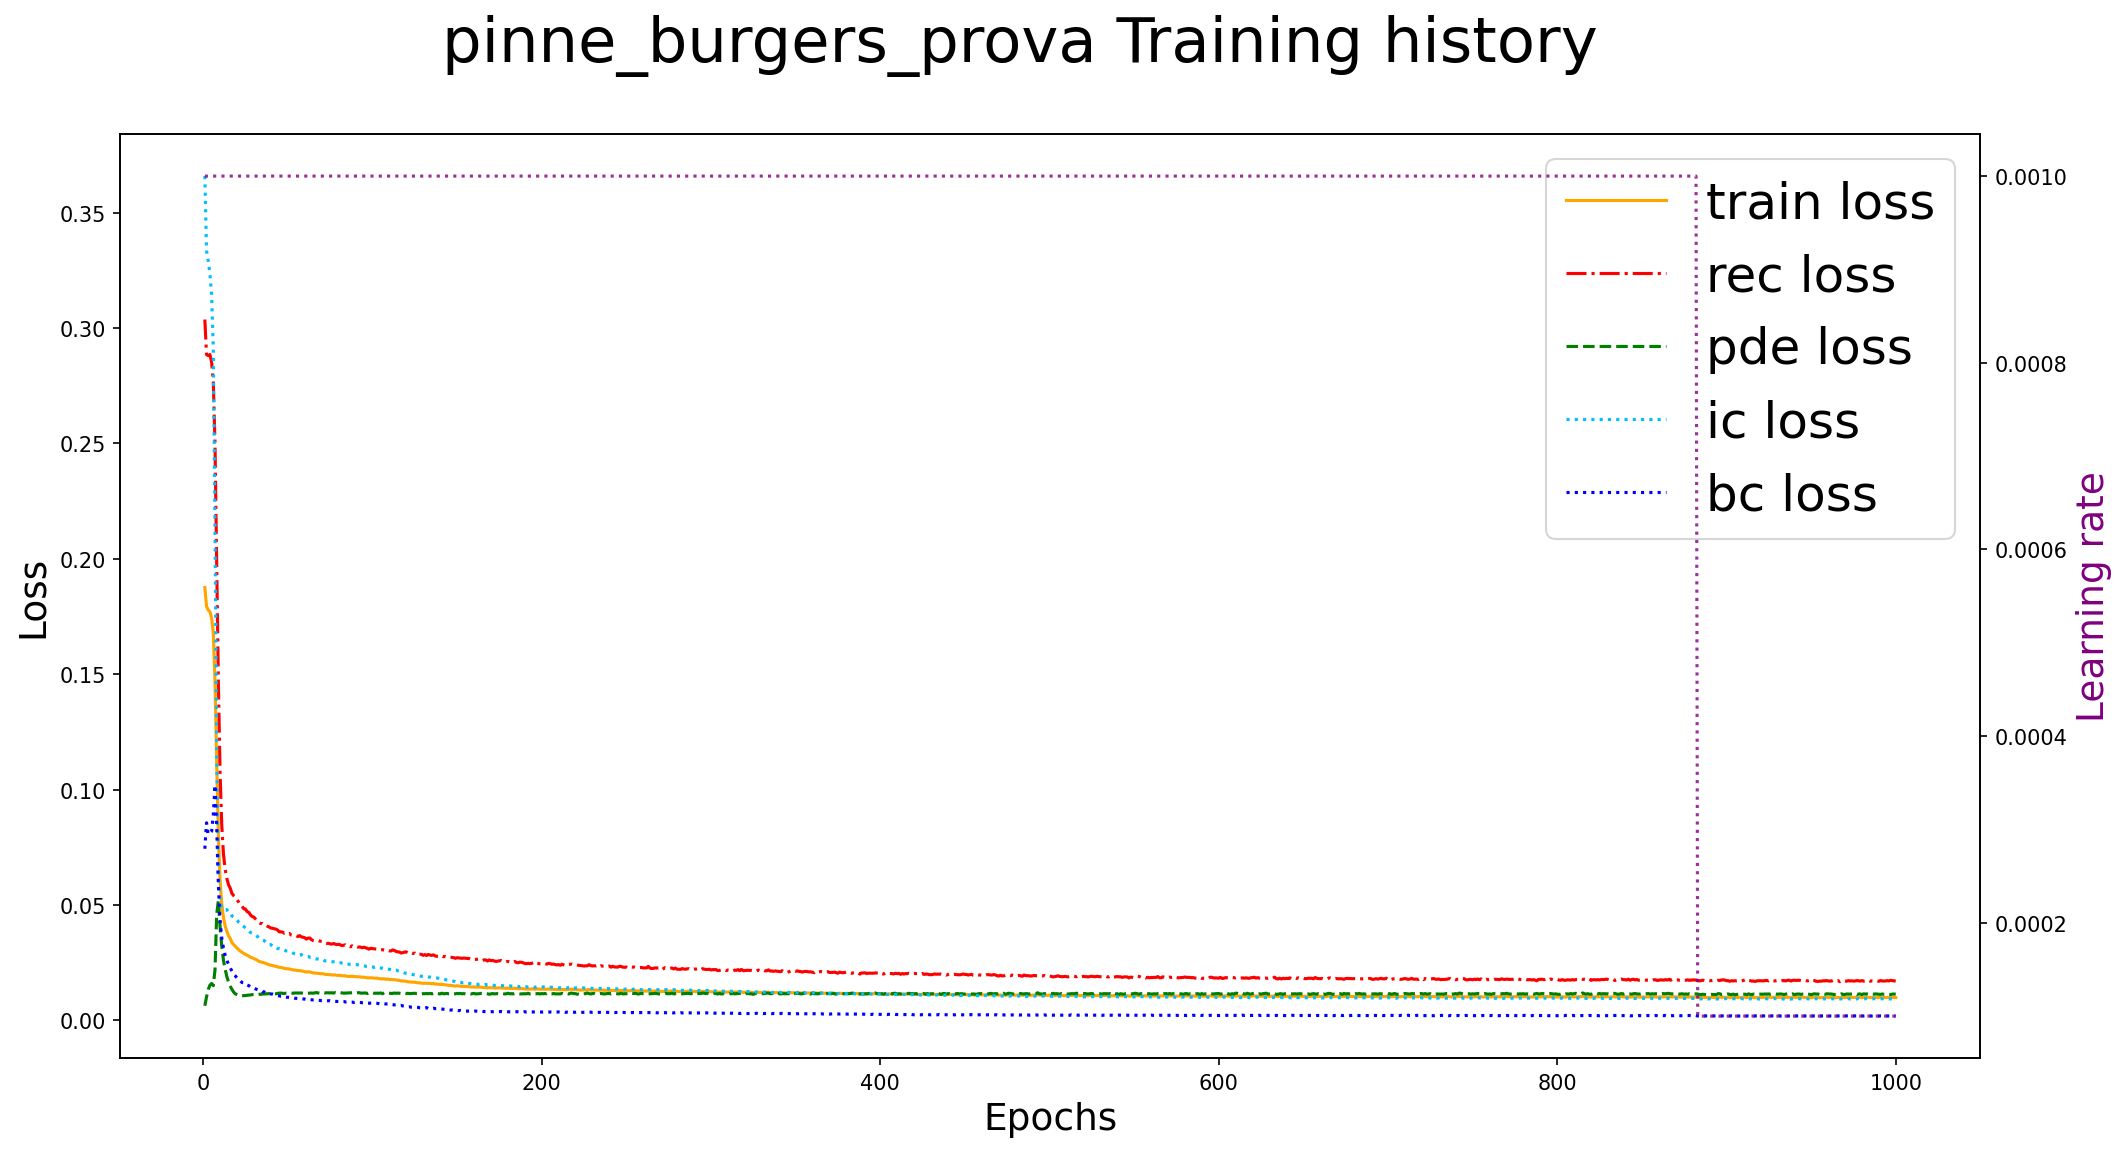

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=150)
fig.suptitle(f"{pinn_model.model_name} Training history", fontsize=30)
ax.plot(range(1,len(pinn_model.training_loss)+1), pinn_model.training_loss, color='orange', linestyle='-', label='train loss')
# others
ax.plot(range(1,len(pinn_model.training_rec_loss)+1), pinn_model.training_rec_loss, color='red', linestyle='-.', label='rec loss')
ax.plot(range(1,len(pinn_model.training_pde_loss)+1), pinn_model.training_pde_loss, color='green', linestyle='--', label='pde loss')
ax.plot(range(1,len(pinn_model.training_ic_loss)+1), pinn_model.training_ic_loss, color='deepskyblue', linestyle=':', label='ic loss')
ax.plot(range(1,len(pinn_model.training_bc_loss)+1), pinn_model.training_bc_loss, color='blue', linestyle=':', label='bc loss')

ax.set_xlabel('Epochs',fontsize=18)
ax.set_ylabel('Loss',fontsize=18)

#ax.set_ylim(0.0, 0.9)

# plot LR
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(1,len(pinn_model.training_loss)+1), pinn_model.learning_rates, color='purple', linestyle=':', label='Learning rates', alpha=0.8)
ax2.set_ylabel("Learning rate", color="purple",fontsize=18)

ax.legend(fontsize=24)

fig.savefig(f"{pinn_model.BASE_PATH_TO_STORE}/{pinn_model.model_name}_training_history.pdf")

fig.show()

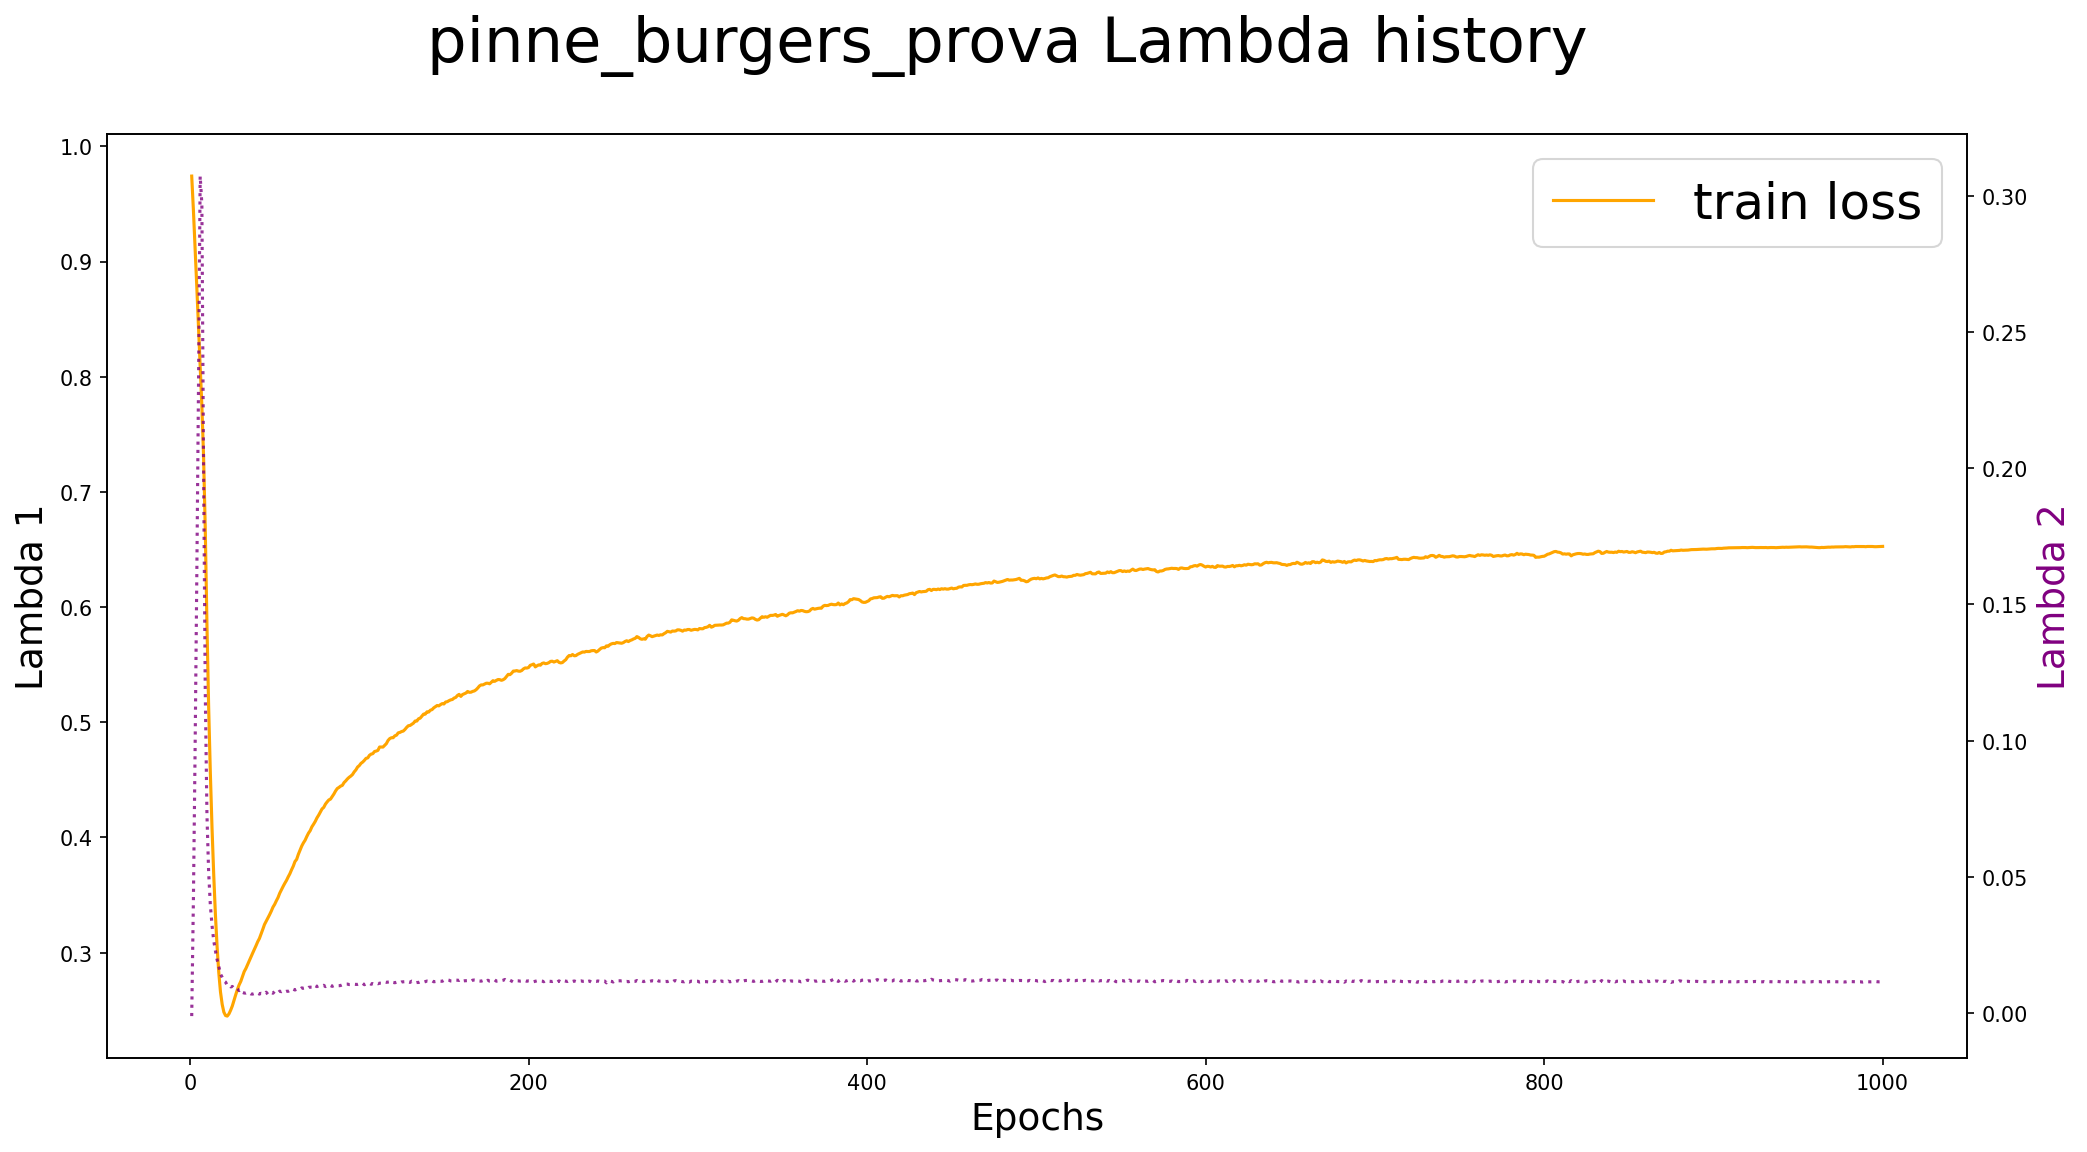

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=150)
fig.suptitle(f"{pinn_model.model_name} Lambda history", fontsize=30)
ax.plot(range(1,len(pinn_model.training_loss)+1), pinn_model.lambda1_history, color='orange', linestyle='-', label='train loss')
ax.set_xlabel('Epochs',fontsize=18)
ax.set_ylabel('Lambda 1',fontsize=18)

# plot LR
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(1,len(pinn_model.training_loss)+1), pinn_model.lambda2_history, color='purple', linestyle=':', label='Learning rates', alpha=0.8)
ax2.set_ylabel("Lambda 2", color="purple",fontsize=18)

ax.legend(fontsize=24)

fig.show()

## 6. Test model

In [ ]:
# load the best model
pinn_model.load_best_model()

Loaded best model: .//pinne_burgers_prova.pth at epoch: 966



In [ ]:
pinn_model.DNN.lambda1

Parameter containing:
tensor([0.6520], requires_grad=True)

In [ ]:
print(f"Infferred parameters:\nlambda_1 = {pinn_model.DNN.lambda1.item():.4f}\nlambda_2 = {pinn_model.DNN.lambda2.item():.4f}")

Infferred parameters:
lambda_1 = 0.6520
lambda_2 = 0.0114


### 6.0 Forward

In [ ]:
import scipy.interpolate

test_pde = Burgers_1D_PDE()

N_POINTS = 128

USE_SAME_SCALE = not True

# Grid data
t = np.linspace(pinn_model._t_min, pinn_model._t_max, N_POINTS)
x = np.linspace(pinn_model._x_min, pinn_model._x_max, N_POINTS)

T, X = np.meshgrid(t,x)

# Pred
coords = np.zeros([N_POINTS**2, 2])
coords[:, 0] = T.flatten()
coords[:, 1] = X.flatten()
X_VAR = Variable(torch.tensor(coords), requires_grad=True).float().to(pinn_model.device)
pred_functor = pinn_model.forward(X_VAR )

pde_pred  = test_pde.compute_burgers(
    X_VAR, pred_functor,
    lambda1 = pinn_model.DNN.lambda1.to(pinn_model.device),
    lambda2 = pinn_model.DNN.lambda2.to(pinn_model.device)
)

pred_func = pred_functor.cpu().squeeze(-1).detach().numpy()
Z_false = pred_func.reshape(128, 128)

# PDE
pde_pred = pde_pred.cpu().squeeze(-1).detach().numpy()
Z_pde    = pde_pred.reshape(128, 128)


# ===== Figure ======
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(18,8))
#and then comes the plot, with the colour-blind-friendly viridis colourmap

levels_pred = np.linspace(pred_func.min().item(), pred_func.max().item(), 75)
im0 = axs[0].contourf(
    T, X, Z_false,
    levels=levels if USE_SAME_SCALE else levels_pred,
    origin = 'lower',
    cmap='jet',
    alpha = 1.0
)
cbar0 = plt.colorbar(im0, ax=axs[0])
cbar0.set_label('u_f(x,t)')

#optional countour lines:
contours = axs[0].contour(T, X, Z_false, colors='yellow');
axs[0].clabel(contours, inline=True, fontsize=8)

axs[0].set_title(f"Predicted function for Burgers Eq. with lambda1={pinn_model.DNN.lambda1.item():.3f}, lambda2={pinn_model.DNN.lambda2.item():.3f}")
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('x (m)')

# PDE
levels_pred_pde = np.linspace(pde_pred.min().item(), pde_pred.max().item(), 75)
im1 = axs[1].contourf(
    T, X, Z_pde,
    levels=levels if USE_SAME_SCALE else levels_pred,
    origin = 'lower',
    cmap='jet',
    alpha = 1.0
)
cbar1 = plt.colorbar(im1, ax=axs[1])
cbar1.set_label('PDE[u_f(x,t)]')

#optional countour lines:
contours1 = axs[1].contour(T, X, Z_pde, colors='yellow');
axs[1].clabel(contours1, inline=True, fontsize=8)

axs[1].set_title(f"Predicted function for Burgers Eq. with lambda1={pinn_model.DNN.lambda1.item():.3f}, lambda2={pinn_model.DNN.lambda2.item():.3f}")
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('x (m)')

fig.savefig(f"{pinn_model.BASE_PATH_TO_STORE}/{pinn_model.model_name}_pred_func.pdf")

plt.show()

Output hidden; open in https://colab.research.google.com to view.